In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import sklearn.svm as svm
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#from module_functions import *
from scipy.ndimage.measurements import label
from collections import deque

In [2]:
"""
    Define Constants
"""
RESIZE_ROWS = 64
RESIZE_COLS = 64

Debug = 1

In [31]:
"""
    Define a class to have the detector details
"""
class Detector():
    def __init__(self, n=10):
        #Window features
        self.color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
        self.spatial_feature_flag = True
        self.hist_feature_flag = True
        self.hog_feature_flag = True
        self.spatial_size=(16, 16)
        self.hist_bins = 32
        self.bins_range=(0, 1.0)
        self.xy_overlap= (0.75, 0.75)
        self.win_size = [128, 72]
        
        #Details to remember previous frame predictions
        self.n = n
        self.recent_boxes = deque([],maxlen=n) # hot windows of the last n images 
        self.current_boxes = None  # current boxes
        self.allboxes = []     
        self.thresh_img = 2  #Heat map threshold for images
        self.thresh_vid = 15  #Heat map threshold for images
        
        #Classifier Details
        self.scaler = None
        self.svc = None
       
        
    def set_scaler(self, scaler):
        self.scaler = scaler
        
    def set_svc(self, svc):
        self.svc = svc
        
    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()

In [4]:
"""
    Load the training, validation and test data.
    This is loaded from a pickle file to avoid preparing the lists everytime.
"""
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars = data['cars']
notcars  = data['notcars']

In [5]:
"""
    EXTRACT FEATURES: This cell has details of extracting the features. The features are:
                      (a) Spatial Color intensity 
                      (b) Histogram of color intensity
                      (c) Histogram of Oriented Gradients(HOG)
""" 

"""
    Define a function to compute binned color features
"""   
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    return features

"""
    Define a function to compute color histogram features 
    Note: The bins_range has to be set to (0, 0.1) for reading png images
           and (0, 256) for reading jpeg images, using matplotlib library.
           STRANGE!!!
"""
def color_hist(img, nbins=32, bins_range=(0, 1.0)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

"""
    Define a function to return HOG features and visualization
"""
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

"""
    Define a function to extract features from a single image
    This function calls bin_spatial(), color_hist() and get_hog_features()
"""
def extract_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature_flag=True, hist_feature_flag=True, 
                        hog_feature_flag=True,
                        bins_range=(0, 1.0)):                
    # Create a list to append feature vectors to
    features = []       

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)    
            
    if spatial_feature_flag == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features.append(spatial_features)
        
    if hist_feature_flag == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=bins_range)
        features.append(hist_features)
        
    if hog_feature_flag == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                #hog_features.append(get_hog_features(feature_image[:,:,channel],
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            #hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False,
                                            feature_vec=True)
    
        features.append(hog_features)
        
    # Concatenate the features and return
    features_cat =np.concatenate(features)

    # Return list of feature vectors
    return features_cat

"""
    Get the features for the list of files
"""
def get_features(files, detector):
    features = []
    for file in files:
        img = mpimg.imread(file)
        img_features = extract_img_features(img, color_space=detector.color_space, spatial_size=detector.spatial_size,
                        hist_bins=detector.hist_bins, orient=detector.orient,
                        pix_per_cell=detector.pix_per_cell, cell_per_block=detector.cell_per_block,
                        hog_channel=detector.hog_channel,
                        spatial_feature_flag=detector.spatial_feature_flag,
                        hist_feature_flag=detector.hist_feature_flag,
                        hog_feature_flag=detector.hog_feature_flag,
                        bins_range=detector.bins_range)
        
        features.append(img_features)
        
    return features

In [6]:
"""
    This cell has the feature normalization step defined. 
    This step is required because different features will have different scale of values.
    Normalization is required to prevent domination of one feature over other features.
"""

"""
    Normalize the feature vectors
"""
def normalize_features(scaler, features):
    features_norm = scaler.transform(np.array(features).reshape(1, -1))
    
    return features_norm

In [7]:
"""
    This cell has the details of training the SVM classifier and
    predicting labels(during inference time).
"""

"""
    This function trains the SVM classifier
"""
def train_classifier(cars=None, notcars=None, detector=None):
    status = 0
    if ((cars == None) or (notcars == None) or (detector == None)):
        print('Invalid cars/notcars list')
        status = -1
        return -1, -1, status
    
    t=time.time()

    #Train Set
    car_features = get_features(cars, detector)
          
    notcar_features = get_features(notcars, detector)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
    
    #Define a SVM Classifier
    # Using a linear SVC 
    svc = LinearSVC()
    #svc = SVC(C=1.0, probability=True)

    # Profiling and training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    if (Debug == 1):
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return X_scaler, svc, status

   
"""
    Define a function which takes the feature vector as the input and returns the predicted label.
"""
def predict_label(svc, feature):
    label = svc.predict(feature)
    
    return label  

In [20]:
"""
    This cell has the details of sliding window and search techinique.
    In this approach we slide a window over the image and at each
    location of the window on the image, we extract the features,
    run the classifier and detect if a car is present at that location.
    We then aggregate the decisions from all the windows to detect the
    presence or absence of a car in the image.
"""

"""   
    Define a function that takes an image,
    start and stop positions in both x and y, 
    window size (x and y dimensions),  
    and overlap fraction (for both x and y)
"""
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

"""
    Define a function to draw bounding boxes
"""
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy


"""
    Define a function that accepts an image 
    and the list of windows to be searched.
    This returns the list of windows which have positive predictions for a car.
"""
def search_windows(img, windows, svc, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    bins_range=(0, 1.0), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feature_flag=True, 
                    hist_feature_flag=True, hog_feature_flag=True):
                
    #List to hold positive detection windows
    found_windows = []
    
    #Iterate over all windows in the list
    for window in windows:
        #Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (RESIZE_ROWS, RESIZE_COLS)) 
        
        #Extract features for that window using extract_img_features()
        features = extract_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feature_flag=spatial_feature_flag, 
                            hist_feature_flag=hist_feature_flag, hog_feature_flag=hog_feature_flag,
                            bins_range=bins_range)
        
        #Scale extracted features to be fed to classifier
        test_features = normalize_features(scaler, features)
        
        #Predict using the classifier
        prediction = predict_label(svc, test_features)
        
        #If positive (prediction == 1) then save the window
        if prediction == 1:
        #if prediction > PREDICT_THRESH:
            found_windows.append(window)
            
    #Return windows for positive detections
    return found_windows

"""
    Perform the search at multiple scales and return the detect
"""
def multiscale_search_window(img, detector=None):
    if (detector == None):
        print('Error in multiscale_search_window, invalid detector')
        
    H, W = img.shape[0], img.shape[1]  
    win_size = detector.win_size
    x_start_stop = [None,None]
    ovlap = detector.xy_overlap
    XY_overlap = [(ovlap[0], ovlap[0]),(ovlap[0],ovlap[1])] 
    yi2,yi3 = (H//2)+35, (H//2)+55    
    Y_start_stop =[[yi2,yi2+win_size[0]/2],[yi3,yi3+win_size[1]/2]] 
    #print('win search pos: ', yi2,yi3)
    
    
    final_windows_list = []
    for i in range(len(win_size)):
        #Choose window details
        xy_overlap=XY_overlap[i]    
        y_start_stop = Y_start_stop[i]   
        xy_window = (win_size[i], win_size[i])
        
    
        windows = slide_window(img, x_start_stop=x_start_stop,
                                y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
        
        found_windows = search_windows(img, windows, detector.svc, 
                                       detector.scaler, color_space=detector.color_space, 
                                       spatial_size=detector.spatial_size, hist_bins=detector.hist_bins, 
                                       bins_range=detector.bins_range, orient=detector.orient, 
                                       pix_per_cell=detector.pix_per_cell, cell_per_block=detector.cell_per_block, 
                                       hog_channel=detector.hog_channel, spatial_feature_flag=detector.spatial_feature_flag, 
                                       hist_feature_flag=detector.hist_feature_flag,
                                       hog_feature_flag=detector.hog_feature_flag,
                                      )
        
        print('windows found: ', len(found_windows))
        
        final_windows_list += found_windows
            
    return final_windows_list




In [37]:
"""
    This cell has details of dealing with false positives and multiple detections.
    (a) We take a heat map of the pixels which indicate how many windows have marked
        each pixel as being a part of a car. 
    (b) We then compare the heatmap with a threshold to decide about the presence of
        the car.
"""

"""
    Add heatmap to the pixels based on the bounding box cordinates.
"""
def add_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    if bbox_list:
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
"""
    Apply threshold on the heatmaps to eliminate false positives and multiple detections.
"""
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

"""
    Draw labeled boxes on the original image. 
    These boxes contain the car detections.
"""
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        #Embed frame number on the image
        #font = cv2.FONT_HERSHEY_COMPLEX
        #coord_str_1 = 'lf: (' + str(bbox[0][0]) + ',' +  str(bbox[0][1]) + ')'
        #coord_str_2 = 'rt: (' + str(bbox[1][0]) + ',' +  str(bbox[1][1]) + ')'
        
        #cv2.putText(img, coord_str_1, (30, (60+30*car_number)), font, 1, (255, 0, 0), 2 )
        #cv2.putText(img, coord_str_2, (130, (30*car_number)), font, 1, (255, 0, 0), 2 )
    
    # Return the image
    return img

In [38]:
"""
    Detection Pipeline for images.
"""

def pipeline_img(img, detector):
    img_copy_orig= np.copy(img)
    img_copy = np.copy(img)
    img_copy = img_copy.astype(np.float32)/255
    
    t=time.time()
    bbox_list = multiscale_search_window(img_copy, detector=detector)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    
    
    print('Num of bboxes: ', len(bbox_list))
    
    # Add heat to each box in box list
    heat = add_heat(img_copy,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, detector.thresh_img)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    windowed_img = draw_labeled_bboxes(img_copy_orig, labels)
    t3 = time.time()
    print(round(t3-t2, 2), 'Seconds for rest ...')
    
    return windowed_img 

In [39]:
"""
    DETECION PIPELINE FOR VIDEO
"""

def pipeline(img, detector):
    img_copy_orig= np.copy(img)
    img_copy = np.copy(img)
    img_copy = img_copy.astype(np.float32)/255
    
    #t=time.time()
    bbox_list = multiscale_search_window(img_copy, detector=detector)
    #t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to search windows ...')
        
    detector.update(bbox_list)
    
    # Add heat to each box in box list
    heat = add_heat(img_copy,detector.allboxes)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, detector.thresh_vid)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    windowed_img = draw_labeled_bboxes(img_copy_orig, labels)
    #t3 = time.time()
    #print(round(t3-t2, 2), 'Seconds for rest ...')
    
    return windowed_img 

"""
    Initialize the detector for running the video pipeline.
"""
def initialize_detector():
    #Loading data from pickle file
    data_file = 'ClassifierData.p'
    with open(data_file, mode='rb') as f:
        data = pickle.load(f)
    
    svc = data['svc'] 
    X_scaler = data['X_scaler']

    detector = Detector(n=30)
    detector.set_scaler(X_scaler)
    detector.set_svc(svc)
    
    return detector

def video_pipeline(img):
    global detector
    global detctr_set
    global frame_cnt
    
    frame_cnt = frame_cnt + 1
    #print(frame_cnt)
   
    if (detctr_set == 0 ):
        initialize_detector()
        detctr_set = 1
        
    windowed_img = pipeline(img, detector)
      
    return windowed_img       


win search pos:  395 415
windows found:  7
windows found:  11
0.43 Seconds to search windows ...
Num of bboxes:  18
0.01 Seconds for rest ...


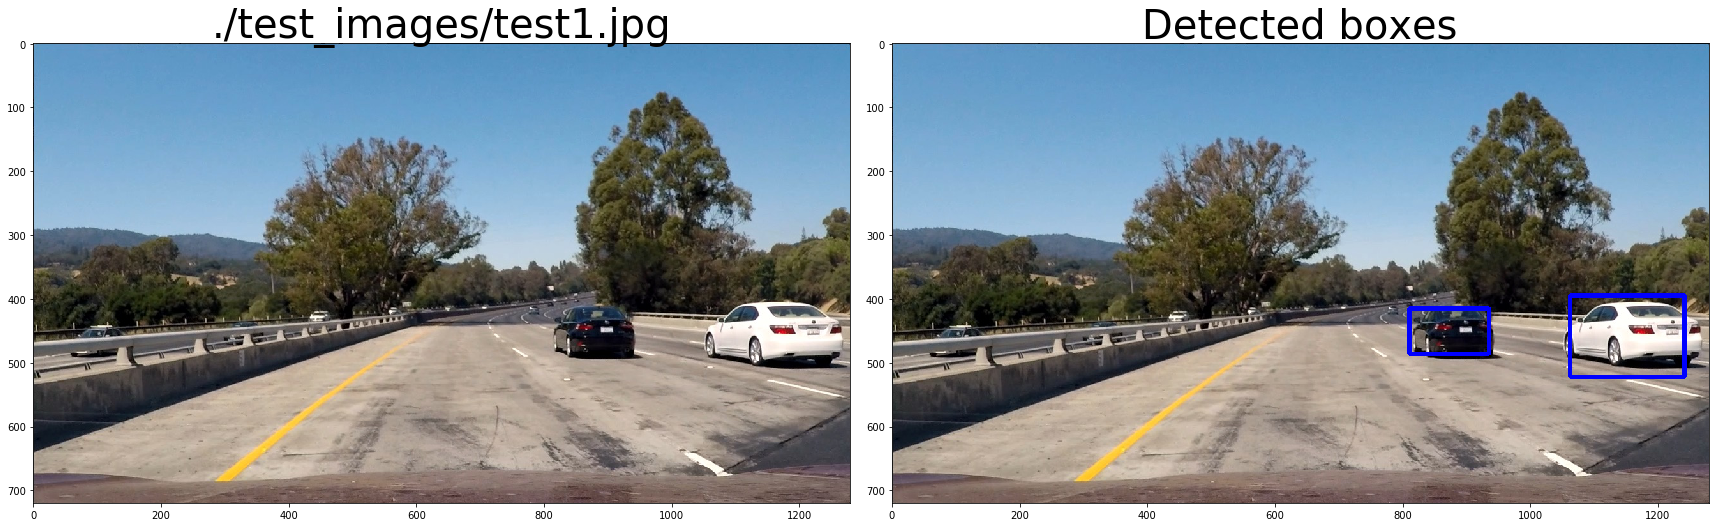

In [41]:
"""
    Test pipeline on an image
"""
test_img_list = ['./test_images/test1.jpg']

save_classifier = 0
detector = Detector()
if (save_classifier == 1):
    X_scaler, svc, status = train_classifier(cars=cars, notcars=notcars, detector=detector)
if (save_classifier == 1):
    pickle_file = 'ClassifierData.p'
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {   'svc':svc, 
                    'X_scaler': X_scaler
                },
            pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    print('Data cached in pickle file.')
    
#Loading data from pickle file
data_file = 'ClassifierData.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']

    
detector.set_scaler(X_scaler)
detector.set_svc(svc)

for test_img in test_img_list:
    img = mpimg.imread(test_img)
    windowed_img = pipeline_img(img, detector)

    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title(test_img, fontsize=40)

    ax2.imshow(windowed_img)
    ax2.set_title('Detected boxes', fontsize=40)
    plt.show()
    #plt.savefig('images/sliding_windows.png')


In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

frame_cnt = 0
detctr_set = 0
output = 'test_video_output.mp4'
clip1 = VideoFileClip("./test_video.mp4")
output_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

1
win search pos:  395 415
windows found:  3
windows found:  6
0.46 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

2
win search pos:  395 415
windows found:  3


  3%|▎         | 1/39 [00:00<00:15,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
3
win search pos:  395 415
windows found:  3


  5%|▌         | 2/39 [00:00<00:15,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
4
win search pos:  395 415
windows found:  3


  8%|▊         | 3/39 [00:01<00:14,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
5
win search pos:  395 415
windows found:  2


 10%|█         | 4/39 [00:01<00:14,  2.45it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
6
win search pos:  395 415
windows found:  3


 13%|█▎        | 5/39 [00:02<00:13,  2.44it/s]

windows found:  11
0.39 Seconds to search windows ...
Num of bboxes:  14
0.01 Seconds for rest ...
7
win search pos:  395 415
windows found:  4


 15%|█▌        | 6/39 [00:02<00:13,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
8
win search pos:  395 415
windows found:  4


 18%|█▊        | 7/39 [00:02<00:13,  2.44it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
9
win search pos:  395 415
windows found:  4


 21%|██        | 8/39 [00:03<00:12,  2.43it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
10
win search pos:  395 415
windows found:  6


 23%|██▎       | 9/39 [00:03<00:12,  2.43it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
11
win search pos:  395 415
windows found:  4


 26%|██▌       | 10/39 [00:04<00:11,  2.43it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
12
win search pos:  395 415
windows found:  4


 28%|██▊       | 11/39 [00:04<00:11,  2.43it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
13
win search pos:  395 415
windows found:  3


 31%|███       | 12/39 [00:04<00:11,  2.43it/s]

windows found:  10
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
14
win search pos:  395 415
windows found:  4


 33%|███▎      | 13/39 [00:05<00:10,  2.43it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
15
win search pos:  395 415
windows found:  4


 36%|███▌      | 14/39 [00:05<00:10,  2.43it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
16
win search pos:  395 415
windows found:  4


 38%|███▊      | 15/39 [00:06<00:09,  2.43it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
17
win search pos:  395 415
windows found:  3


 41%|████      | 16/39 [00:06<00:09,  2.31it/s]

windows found:  6
0.46 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
18
win search pos:  395 415
windows found:  4


 44%|████▎     | 17/39 [00:07<00:09,  2.33it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
19
win search pos:  395 415
windows found:  3


 46%|████▌     | 18/39 [00:07<00:09,  2.31it/s]

windows found:  5
0.42 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
20
win search pos:  395 415
windows found:  5


 49%|████▊     | 19/39 [00:07<00:08,  2.35it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
21
win search pos:  395 415
windows found:  3


 51%|█████▏    | 20/39 [00:08<00:08,  2.33it/s]

windows found:  7
0.41 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
22
win search pos:  395 415
windows found:  4


 54%|█████▍    | 21/39 [00:08<00:07,  2.36it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
23
win search pos:  395 415
windows found:  3


 56%|█████▋    | 22/39 [00:09<00:07,  2.34it/s]

windows found:  5
0.41 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
24
win search pos:  395 415
windows found:  3


 59%|█████▉    | 23/39 [00:09<00:06,  2.32it/s]

windows found:  6
0.41 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
25
win search pos:  395 415
windows found:  3


 62%|██████▏   | 24/39 [00:10<00:06,  2.35it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
26
win search pos:  395 415
windows found:  4


 64%|██████▍   | 25/39 [00:10<00:06,  2.33it/s]

windows found:  6
0.41 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
27
win search pos:  395 415
windows found:  4


 67%|██████▋   | 26/39 [00:10<00:05,  2.36it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
28
win search pos:  395 415
windows found:  4


 69%|██████▉   | 27/39 [00:11<00:05,  2.33it/s]

windows found:  5
0.42 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
29
win search pos:  395 415
windows found:  4


 72%|███████▏  | 28/39 [00:11<00:04,  2.36it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
30
win search pos:  395 415
windows found:  3


 74%|███████▍  | 29/39 [00:12<00:04,  2.34it/s]

windows found:  7
0.41 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
31
win search pos:  395 415
windows found:  3


 77%|███████▋  | 30/39 [00:12<00:03,  2.33it/s]

windows found:  8
0.4 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
32
win search pos:  395 415
windows found:  2


 79%|███████▉  | 31/39 [00:13<00:03,  2.36it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
33
win search pos:  395 415
windows found:  2


 82%|████████▏ | 32/39 [00:13<00:02,  2.34it/s]

windows found:  7
0.41 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
34
win search pos:  395 415
windows found:  2


 85%|████████▍ | 33/39 [00:13<00:02,  2.37it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
35
win search pos:  395 415
windows found:  4


 87%|████████▋ | 34/39 [00:14<00:02,  2.35it/s]

windows found:  10
0.41 Seconds to search windows ...
Num of bboxes:  14
0.01 Seconds for rest ...
36
win search pos:  395 415
windows found:  4


 90%|████████▉ | 35/39 [00:14<00:01,  2.38it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
37
win search pos:  395 415
windows found:  5


 92%|█████████▏| 36/39 [00:15<00:01,  2.35it/s]

windows found:  8
0.41 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
38
win search pos:  395 415
windows found:  5


 95%|█████████▍| 37/39 [00:15<00:00,  2.33it/s]

windows found:  6
0.4 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
39
win search pos:  395 415
windows found:  6


 97%|█████████▋| 38/39 [00:16<00:00,  2.36it/s]

windows found:  10
0.39 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 15.8 s, sys: 354 ms, total: 16.1 s
Wall time: 16.8 s


In [118]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

frame_cnt = 0
detctr_set = 0
output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

1
win search pos:  395 405
windows found:  0
windows found:  0
0.47 Seconds to search windows ...
Num of bboxes:  0
0.02 Seconds for rest ...
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

2
win search pos:  395 405
windows found:  0


  0%|          | 1/1261 [00:00<08:41,  2.41it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.02 Seconds for rest ...
3
win search pos:  395 405
windows found:  0


  0%|          | 2/1261 [00:00<08:39,  2.42it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
4
win search pos:  395 405
windows found:  0


  0%|          | 3/1261 [00:01<08:35,  2.44it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
5
win search pos:  395 405
windows found:  0


  0%|          | 4/1261 [00:01<08:32,  2.45it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
6
win search pos:  395 405
windows found:  0


  0%|          | 5/1261 [00:02<08:29,  2.47it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
7
win search pos:  395 405
windows found:  0


  0%|          | 6/1261 [00:02<08:25,  2.48it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
8
win search pos:  395 405
windows found:  0


  1%|          | 7/1261 [00:02<08:23,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
9
win search pos:  395 405
windows found:  0


  1%|          | 8/1261 [00:03<08:21,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
10
win search pos:  395 405
windows found:  0


  1%|          | 9/1261 [00:03<08:19,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
11
win search pos:  395 405
windows found:  0


  1%|          | 10/1261 [00:04<08:18,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
12
win search pos:  395 405
windows found:  0


  1%|          | 11/1261 [00:04<08:17,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
13
win search pos:  395 405
windows found:  0


  1%|          | 12/1261 [00:04<08:16,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
14
win search pos:  395 405
windows found:  0


  1%|          | 13/1261 [00:05<08:52,  2.35it/s]

windows found:  1
0.48 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
15
win search pos:  395 405
windows found:  0


  1%|          | 14/1261 [00:05<08:43,  2.38it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
16
win search pos:  395 405
windows found:  0


  1%|          | 15/1261 [00:06<08:36,  2.41it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
17
win search pos:  395 405
windows found:  0


  1%|▏         | 16/1261 [00:06<09:05,  2.28it/s]

windows found:  0
0.48 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
18
win search pos:  395 405
windows found:  0


  1%|▏         | 17/1261 [00:07<08:52,  2.34it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
19
win search pos:  395 405
windows found:  0


  1%|▏         | 18/1261 [00:07<08:42,  2.38it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
20
win search pos:  395 405
windows found:  0


  2%|▏         | 19/1261 [00:07<08:31,  2.43it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
21
win search pos:  395 405
windows found:  0


  2%|▏         | 20/1261 [00:08<08:23,  2.46it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
22
win search pos:  395 405
windows found:  0


  2%|▏         | 21/1261 [00:08<08:18,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
23
win search pos:  395 405
windows found:  0


  2%|▏         | 22/1261 [00:08<08:13,  2.51it/s]

windows found:  0
0.37 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
24
win search pos:  395 405
windows found:  0


  2%|▏         | 23/1261 [00:09<08:12,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
25
win search pos:  395 405
windows found:  0


  2%|▏         | 24/1261 [00:09<08:09,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
26
win search pos:  395 405
windows found:  0


  2%|▏         | 25/1261 [00:10<08:08,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
27
win search pos:  395 405
windows found:  0


  2%|▏         | 26/1261 [00:10<08:07,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
28
win search pos:  395 405
windows found:  0


  2%|▏         | 27/1261 [00:10<08:06,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
29
win search pos:  395 405
windows found:  0


  2%|▏         | 28/1261 [00:11<08:04,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
30
win search pos:  395 405
windows found:  0


  2%|▏         | 29/1261 [00:11<08:05,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
31
win search pos:  395 405
windows found:  0


  2%|▏         | 30/1261 [00:12<08:04,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
32
win search pos:  395 405
windows found:  0


  2%|▏         | 31/1261 [00:12<08:01,  2.55it/s]

windows found:  0
0.37 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
33
win search pos:  395 405
windows found:  0


  3%|▎         | 32/1261 [00:12<08:00,  2.56it/s]

windows found:  0
0.37 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
34
win search pos:  395 405
windows found:  0


  3%|▎         | 33/1261 [00:13<07:58,  2.56it/s]

windows found:  0
0.37 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
35
win search pos:  395 405
windows found:  0


  3%|▎         | 34/1261 [00:13<07:59,  2.56it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
36
win search pos:  395 405
windows found:  0


  3%|▎         | 35/1261 [00:14<07:59,  2.56it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
37
win search pos:  395 405
windows found:  0


  3%|▎         | 36/1261 [00:14<07:59,  2.56it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
38
win search pos:  395 405
windows found:  0


  3%|▎         | 37/1261 [00:14<07:59,  2.55it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
39
win search pos:  395 405
windows found:  0


  3%|▎         | 38/1261 [00:15<07:59,  2.55it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
40
win search pos:  395 405
windows found:  0


  3%|▎         | 39/1261 [00:15<07:59,  2.55it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
41
win search pos:  395 405
windows found:  0


  3%|▎         | 40/1261 [00:16<08:00,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
42
win search pos:  395 405
windows found:  0


  3%|▎         | 41/1261 [00:16<07:59,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
43
win search pos:  395 405
windows found:  0


  3%|▎         | 42/1261 [00:16<07:59,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
44
win search pos:  395 405
windows found:  0


  3%|▎         | 43/1261 [00:17<08:00,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
45
win search pos:  395 405
windows found:  0


  3%|▎         | 44/1261 [00:17<07:59,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
46
win search pos:  395 405
windows found:  0


  4%|▎         | 45/1261 [00:18<07:59,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
47
win search pos:  395 405
windows found:  0


  4%|▎         | 46/1261 [00:18<08:00,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
48
win search pos:  395 405
windows found:  0


  4%|▎         | 47/1261 [00:18<08:00,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
49
win search pos:  395 405
windows found:  0


  4%|▍         | 48/1261 [00:19<08:00,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
50
win search pos:  395 405
windows found:  0


  4%|▍         | 49/1261 [00:19<07:58,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
51
win search pos:  395 405
windows found:  0


  4%|▍         | 50/1261 [00:19<07:58,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
52
win search pos:  395 405
windows found:  0


  4%|▍         | 51/1261 [00:20<07:58,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
53
win search pos:  395 405
windows found:  0


  4%|▍         | 52/1261 [00:20<07:59,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
54
win search pos:  395 405
windows found:  0


  4%|▍         | 53/1261 [00:21<07:58,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
55
win search pos:  395 405
windows found:  0


  4%|▍         | 54/1261 [00:21<07:57,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
56
win search pos:  395 405
windows found:  0


  4%|▍         | 55/1261 [00:21<07:56,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
57
win search pos:  395 405
windows found:  0


  4%|▍         | 56/1261 [00:22<07:56,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
58
win search pos:  395 405
windows found:  0


  5%|▍         | 57/1261 [00:22<07:56,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
59
win search pos:  395 405
windows found:  0


  5%|▍         | 58/1261 [00:23<07:57,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
60
win search pos:  395 405
windows found:  0


  5%|▍         | 59/1261 [00:23<08:30,  2.35it/s]

windows found:  0
0.47 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
61
win search pos:  395 405
windows found:  0


  5%|▍         | 60/1261 [00:24<08:23,  2.39it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
62
win search pos:  395 405
windows found:  0


  5%|▍         | 61/1261 [00:24<08:14,  2.43it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
63
win search pos:  395 405
windows found:  0


  5%|▍         | 62/1261 [00:24<08:08,  2.46it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
64
win search pos:  395 405
windows found:  0


  5%|▍         | 63/1261 [00:25<08:03,  2.48it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
65
win search pos:  395 405
windows found:  0


  5%|▌         | 64/1261 [00:25<08:01,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
66
win search pos:  395 405
windows found:  0


  5%|▌         | 65/1261 [00:26<07:59,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
67
win search pos:  395 405
windows found:  0


  5%|▌         | 66/1261 [00:26<07:57,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
68
win search pos:  395 405
windows found:  0


  5%|▌         | 67/1261 [00:26<07:57,  2.50it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
69
win search pos:  395 405
windows found:  0


  5%|▌         | 68/1261 [00:27<07:56,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
70
win search pos:  395 405
windows found:  0


  5%|▌         | 69/1261 [00:27<07:55,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
71
win search pos:  395 405
windows found:  0


  6%|▌         | 70/1261 [00:28<07:54,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
72
win search pos:  395 405
windows found:  0


  6%|▌         | 71/1261 [00:28<07:53,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
73
win search pos:  395 405
windows found:  0


  6%|▌         | 72/1261 [00:28<07:53,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
74
win search pos:  395 405
windows found:  0


  6%|▌         | 73/1261 [00:29<07:52,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
75
win search pos:  395 405
windows found:  0


  6%|▌         | 74/1261 [00:29<07:52,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
76
win search pos:  395 405
windows found:  0


  6%|▌         | 75/1261 [00:30<07:52,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
77
win search pos:  395 405
windows found:  0


  6%|▌         | 76/1261 [00:30<07:51,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
78
win search pos:  395 405
windows found:  0


  6%|▌         | 77/1261 [00:30<07:51,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
79
win search pos:  395 405
windows found:  0


  6%|▌         | 78/1261 [00:31<07:50,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
80
win search pos:  395 405
windows found:  0


  6%|▋         | 79/1261 [00:31<07:50,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
81
win search pos:  395 405
windows found:  0


  6%|▋         | 80/1261 [00:32<07:49,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
82
win search pos:  395 405
windows found:  0


  6%|▋         | 81/1261 [00:32<07:49,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
83
win search pos:  395 405
windows found:  0


  7%|▋         | 82/1261 [00:32<07:48,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
84
win search pos:  395 405
windows found:  0


  7%|▋         | 83/1261 [00:33<07:48,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
85
win search pos:  395 405
windows found:  0


  7%|▋         | 84/1261 [00:33<07:48,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
86
win search pos:  395 405
windows found:  0


  7%|▋         | 85/1261 [00:33<07:47,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
87
win search pos:  395 405
windows found:  0


  7%|▋         | 86/1261 [00:34<07:47,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
88
win search pos:  395 405
windows found:  0


  7%|▋         | 87/1261 [00:34<07:45,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
89
win search pos:  395 405
windows found:  0


  7%|▋         | 88/1261 [00:35<07:45,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
90
win search pos:  395 405
windows found:  0


  7%|▋         | 89/1261 [00:35<07:45,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
91
win search pos:  395 405
windows found:  0


  7%|▋         | 90/1261 [00:35<07:46,  2.51it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
92
win search pos:  395 405
windows found:  0


  7%|▋         | 91/1261 [00:36<07:43,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
93
win search pos:  395 405
windows found:  0


  7%|▋         | 92/1261 [00:36<07:41,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
94
win search pos:  395 405
windows found:  0


  7%|▋         | 93/1261 [00:37<07:41,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
95
win search pos:  395 405
windows found:  0


  7%|▋         | 94/1261 [00:37<07:42,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
96
win search pos:  395 405
windows found:  0


  8%|▊         | 95/1261 [00:37<07:40,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
97
win search pos:  395 405
windows found:  0


  8%|▊         | 96/1261 [00:38<07:40,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
98
win search pos:  395 405
windows found:  0


  8%|▊         | 97/1261 [00:38<07:40,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
99
win search pos:  395 405
windows found:  0


  8%|▊         | 98/1261 [00:39<07:38,  2.54it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
100
win search pos:  395 405
windows found:  0


  8%|▊         | 99/1261 [00:39<07:38,  2.53it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
101
win search pos:  395 405
windows found:  0


  8%|▊         | 100/1261 [00:39<07:38,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
102
win search pos:  395 405
windows found:  0


  8%|▊         | 101/1261 [00:40<07:38,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
103
win search pos:  395 405
windows found:  0


  8%|▊         | 102/1261 [00:40<07:38,  2.53it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
104
win search pos:  395 405
windows found:  0


  8%|▊         | 103/1261 [00:41<07:39,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
105
win search pos:  395 405
windows found:  0


  8%|▊         | 104/1261 [00:41<07:38,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
106
win search pos:  395 405
windows found:  0


  8%|▊         | 105/1261 [00:41<07:39,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
107
win search pos:  395 405
windows found:  0


  8%|▊         | 106/1261 [00:42<07:38,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
108
win search pos:  395 405
windows found:  0


  8%|▊         | 107/1261 [00:42<07:39,  2.51it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
109
win search pos:  395 405
windows found:  0


  9%|▊         | 108/1261 [00:43<07:38,  2.52it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
110
win search pos:  395 405
windows found:  0


  9%|▊         | 109/1261 [00:43<07:38,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
111
win search pos:  395 405
windows found:  0


  9%|▊         | 110/1261 [00:43<07:37,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
112
win search pos:  395 405
windows found:  0


  9%|▉         | 111/1261 [00:44<07:37,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
113
win search pos:  395 405
windows found:  0


  9%|▉         | 112/1261 [00:44<07:37,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
114
win search pos:  395 405
windows found:  0


  9%|▉         | 113/1261 [00:45<07:37,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
115
win search pos:  395 405
windows found:  0


  9%|▉         | 114/1261 [00:45<07:37,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
116
win search pos:  395 405
windows found:  0


  9%|▉         | 115/1261 [00:45<07:37,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
117
win search pos:  395 405
windows found:  0


  9%|▉         | 116/1261 [00:46<07:37,  2.50it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
118
win search pos:  395 405
windows found:  0


  9%|▉         | 117/1261 [00:46<07:35,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
119
win search pos:  395 405
windows found:  0


  9%|▉         | 118/1261 [00:47<07:35,  2.51it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
120
win search pos:  395 405
windows found:  0


  9%|▉         | 119/1261 [00:47<07:35,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
121
win search pos:  395 405
windows found:  0


 10%|▉         | 120/1261 [00:47<07:35,  2.50it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
122
win search pos:  395 405
windows found:  0


 10%|▉         | 121/1261 [00:48<07:33,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
123
win search pos:  395 405
windows found:  0


 10%|▉         | 122/1261 [00:48<07:33,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
124
win search pos:  395 405
windows found:  0


 10%|▉         | 123/1261 [00:49<07:32,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
125
win search pos:  395 405
windows found:  0


 10%|▉         | 124/1261 [00:49<07:32,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
126
win search pos:  395 405
windows found:  0


 10%|▉         | 125/1261 [00:49<07:31,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
127
win search pos:  395 405
windows found:  0


 10%|▉         | 126/1261 [00:50<07:32,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
128
win search pos:  395 405
windows found:  0


 10%|█         | 127/1261 [00:50<07:31,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
129
win search pos:  395 405
windows found:  0


 10%|█         | 128/1261 [00:51<07:31,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
130
win search pos:  395 405
windows found:  0


 10%|█         | 129/1261 [00:51<07:30,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
131
win search pos:  395 405
windows found:  0


 10%|█         | 130/1261 [00:51<07:30,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
132
win search pos:  395 405
windows found:  0


 10%|█         | 131/1261 [00:52<07:29,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
133
win search pos:  395 405
windows found:  0


 10%|█         | 132/1261 [00:52<07:28,  2.52it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
134
win search pos:  395 405
windows found:  0


 11%|█         | 133/1261 [00:53<07:29,  2.51it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
135
win search pos:  395 405
windows found:  0


 11%|█         | 134/1261 [00:53<07:29,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
136
win search pos:  395 405
windows found:  0


 11%|█         | 135/1261 [00:53<07:29,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
137
win search pos:  395 405
windows found:  0


 11%|█         | 136/1261 [00:54<07:29,  2.50it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
138
win search pos:  395 405
windows found:  1


 11%|█         | 137/1261 [00:54<07:28,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
139
win search pos:  395 405
windows found:  0


 11%|█         | 138/1261 [00:55<07:28,  2.50it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
140
win search pos:  395 405
windows found:  0


 11%|█         | 139/1261 [00:55<07:28,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
141
win search pos:  395 405
windows found:  0


 11%|█         | 140/1261 [00:55<07:27,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
142
win search pos:  395 405
windows found:  0


 11%|█         | 141/1261 [00:56<07:27,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
143
win search pos:  395 405
windows found:  0


 11%|█▏        | 142/1261 [00:56<07:26,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
144
win search pos:  395 405
windows found:  0


 11%|█▏        | 143/1261 [00:57<07:26,  2.50it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
145
win search pos:  395 405
windows found:  0


 11%|█▏        | 144/1261 [00:57<07:26,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
146
win search pos:  395 405
windows found:  0


 11%|█▏        | 145/1261 [00:57<07:26,  2.50it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
147
win search pos:  395 405
windows found:  0


 12%|█▏        | 146/1261 [00:58<07:25,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
148
win search pos:  395 405
windows found:  0


 12%|█▏        | 147/1261 [00:58<07:25,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
149
win search pos:  395 405
windows found:  0


 12%|█▏        | 148/1261 [00:59<07:24,  2.50it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
150
win search pos:  395 405
windows found:  0


 12%|█▏        | 149/1261 [00:59<07:23,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
151
win search pos:  395 405
windows found:  0


 12%|█▏        | 150/1261 [00:59<07:23,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
152
win search pos:  395 405
windows found:  0


 12%|█▏        | 151/1261 [01:00<07:21,  2.51it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
153
win search pos:  395 405
windows found:  0


 12%|█▏        | 152/1261 [01:00<07:20,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
154
win search pos:  395 405
windows found:  0


 12%|█▏        | 153/1261 [01:01<07:19,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  0
0.01 Seconds for rest ...
155
win search pos:  395 405
windows found:  1


 12%|█▏        | 154/1261 [01:01<07:19,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
156
win search pos:  395 405
windows found:  3


 12%|█▏        | 155/1261 [01:01<07:18,  2.52it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
157
win search pos:  395 405
windows found:  3


 12%|█▏        | 156/1261 [01:02<08:32,  2.16it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
158
win search pos:  395 405
windows found:  3


 12%|█▏        | 157/1261 [01:03<09:23,  1.96it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
159
win search pos:  395 405
windows found:  3


 13%|█▎        | 158/1261 [01:03<10:01,  1.84it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
160
win search pos:  395 405
windows found:  3


 13%|█▎        | 159/1261 [01:04<10:26,  1.76it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
161
win search pos:  395 405
windows found:  3


 13%|█▎        | 160/1261 [01:04<10:45,  1.71it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
162
win search pos:  395 405
windows found:  3


 13%|█▎        | 161/1261 [01:05<10:57,  1.67it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
163
win search pos:  395 405
windows found:  3


 13%|█▎        | 162/1261 [01:06<11:07,  1.65it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
164
win search pos:  395 405
windows found:  4


 13%|█▎        | 163/1261 [01:06<11:15,  1.63it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
165
win search pos:  395 405
windows found:  3


 13%|█▎        | 164/1261 [01:07<11:20,  1.61it/s]

windows found:  1
0.61 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
166
win search pos:  395 405
windows found:  3


 13%|█▎        | 165/1261 [01:08<11:21,  1.61it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
167
win search pos:  395 405
windows found:  3


 13%|█▎        | 166/1261 [01:08<11:22,  1.60it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
168
win search pos:  395 405
windows found:  3


 13%|█▎        | 167/1261 [01:09<11:24,  1.60it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
169
win search pos:  395 405
windows found:  3


 13%|█▎        | 168/1261 [01:09<11:25,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
170
win search pos:  395 405
windows found:  3


 13%|█▎        | 169/1261 [01:10<11:26,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
171
win search pos:  395 405
windows found:  2


 13%|█▎        | 170/1261 [01:11<11:25,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
172
win search pos:  395 405
windows found:  2


 14%|█▎        | 171/1261 [01:11<11:26,  1.59it/s]

windows found:  3
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
173
win search pos:  395 405
windows found:  2


 14%|█▎        | 172/1261 [01:12<11:25,  1.59it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  3
0.02 Seconds for rest ...
174
win search pos:  395 405
windows found:  2


 14%|█▎        | 173/1261 [01:13<11:28,  1.58it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
175
win search pos:  395 405
windows found:  2


 14%|█▍        | 174/1261 [01:13<11:27,  1.58it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
176
win search pos:  395 405
windows found:  2


 14%|█▍        | 175/1261 [01:14<11:26,  1.58it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
177
win search pos:  395 405
windows found:  1


 14%|█▍        | 176/1261 [01:15<11:25,  1.58it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  3
0.02 Seconds for rest ...
178
win search pos:  395 405
windows found:  2


 14%|█▍        | 177/1261 [01:15<11:23,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
179
win search pos:  395 405
windows found:  2


 14%|█▍        | 178/1261 [01:16<11:25,  1.58it/s]

windows found:  3
0.62 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
180
win search pos:  395 405
windows found:  2


 14%|█▍        | 179/1261 [01:16<11:24,  1.58it/s]

windows found:  3
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
181
win search pos:  395 405
windows found:  3


 14%|█▍        | 180/1261 [01:17<11:21,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
182
win search pos:  395 405
windows found:  3


 14%|█▍        | 181/1261 [01:18<11:19,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
183
win search pos:  395 405
windows found:  3


 14%|█▍        | 182/1261 [01:18<11:19,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
184
win search pos:  395 405
windows found:  3


 15%|█▍        | 183/1261 [01:19<11:17,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
185
win search pos:  395 405
windows found:  3


 15%|█▍        | 184/1261 [01:20<11:17,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
186
win search pos:  395 405
windows found:  2


 15%|█▍        | 185/1261 [01:20<11:15,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
187
win search pos:  395 405
windows found:  2


 15%|█▍        | 186/1261 [01:21<11:13,  1.60it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
188
win search pos:  395 405
windows found:  2


 15%|█▍        | 187/1261 [01:21<11:14,  1.59it/s]

windows found:  4
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
189
win search pos:  395 405
windows found:  3


 15%|█▍        | 188/1261 [01:22<11:13,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
190
win search pos:  395 405
windows found:  2


 15%|█▍        | 189/1261 [01:23<11:12,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
191
win search pos:  395 405
windows found:  4


 15%|█▌        | 190/1261 [01:23<11:14,  1.59it/s]

windows found:  4
0.61 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
192
win search pos:  395 405
windows found:  3


 15%|█▌        | 191/1261 [01:24<11:12,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
193
win search pos:  395 405
windows found:  4


 15%|█▌        | 192/1261 [01:25<11:11,  1.59it/s]

windows found:  5
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
194
win search pos:  395 405
windows found:  4


 15%|█▌        | 193/1261 [01:25<11:12,  1.59it/s]

windows found:  5
0.61 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
195
win search pos:  395 405
windows found:  5


 15%|█▌        | 194/1261 [01:26<11:11,  1.59it/s]

windows found:  4
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
196
win search pos:  395 405
windows found:  4


 15%|█▌        | 195/1261 [01:26<11:10,  1.59it/s]

windows found:  6
0.6 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
197
win search pos:  395 405
windows found:  6


 16%|█▌        | 196/1261 [01:27<11:09,  1.59it/s]

windows found:  5
0.6 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
198
win search pos:  395 405
windows found:  6


 16%|█▌        | 197/1261 [01:28<11:09,  1.59it/s]

windows found:  5
0.6 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
199
win search pos:  395 405
windows found:  5


 16%|█▌        | 198/1261 [01:28<11:09,  1.59it/s]

windows found:  4
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
200
win search pos:  395 405
windows found:  4


 16%|█▌        | 199/1261 [01:29<11:07,  1.59it/s]

windows found:  4
0.6 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
201
win search pos:  395 405
windows found:  5


 16%|█▌        | 200/1261 [01:30<11:06,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
202
win search pos:  395 405
windows found:  5


 16%|█▌        | 201/1261 [01:30<11:04,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
203
win search pos:  395 405
windows found:  5


 16%|█▌        | 202/1261 [01:31<11:04,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
204
win search pos:  395 405
windows found:  5


 16%|█▌        | 203/1261 [01:32<11:04,  1.59it/s]

windows found:  3
0.61 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
205
win search pos:  395 405
windows found:  5


 16%|█▌        | 204/1261 [01:32<11:05,  1.59it/s]

windows found:  5
0.61 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
206
win search pos:  395 405
windows found:  5


 16%|█▋        | 205/1261 [01:33<11:06,  1.59it/s]

windows found:  5
0.61 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
207
win search pos:  395 405
windows found:  4


 16%|█▋        | 206/1261 [01:33<11:05,  1.58it/s]

windows found:  5
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
208
win search pos:  395 405
windows found:  5


 16%|█▋        | 207/1261 [01:34<11:04,  1.59it/s]

windows found:  4
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
209
win search pos:  395 405
windows found:  5


 16%|█▋        | 208/1261 [01:35<11:03,  1.59it/s]

windows found:  6
0.6 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
210
win search pos:  395 405
windows found:  5


 17%|█▋        | 209/1261 [01:35<11:02,  1.59it/s]

windows found:  5
0.6 Seconds to search windows ...
Num of bboxes:  10
0.02 Seconds for rest ...
211
win search pos:  395 405
windows found:  5


 17%|█▋        | 210/1261 [01:36<11:01,  1.59it/s]

windows found:  4
0.6 Seconds to search windows ...
Num of bboxes:  9
0.02 Seconds for rest ...
212
win search pos:  395 405
windows found:  4


 17%|█▋        | 211/1261 [01:37<11:00,  1.59it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
213
win search pos:  395 405
windows found:  5


 17%|█▋        | 212/1261 [01:37<10:59,  1.59it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
214
win search pos:  395 405
windows found:  4


 17%|█▋        | 213/1261 [01:38<10:58,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
215
win search pos:  395 405
windows found:  4


 17%|█▋        | 214/1261 [01:38<10:57,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
216
win search pos:  395 405
windows found:  4


 17%|█▋        | 215/1261 [01:39<10:57,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
217
win search pos:  395 405
windows found:  5


 17%|█▋        | 216/1261 [01:40<10:57,  1.59it/s]

windows found:  1
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
218
win search pos:  395 405
windows found:  3


 17%|█▋        | 217/1261 [01:40<10:57,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
219
win search pos:  395 405
windows found:  5


 17%|█▋        | 218/1261 [01:41<10:56,  1.59it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
220
win search pos:  395 405
windows found:  5


 17%|█▋        | 219/1261 [01:42<10:55,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
221
win search pos:  395 405
windows found:  4


 17%|█▋        | 220/1261 [01:42<10:54,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  7
0.02 Seconds for rest ...
222
win search pos:  395 405
windows found:  4


 18%|█▊        | 221/1261 [01:43<10:55,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
223
win search pos:  395 405
windows found:  4


 18%|█▊        | 222/1261 [01:43<10:54,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
224
win search pos:  395 405
windows found:  3


 18%|█▊        | 223/1261 [01:44<10:53,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
225
win search pos:  395 405
windows found:  4


 18%|█▊        | 224/1261 [01:45<10:51,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
226
win search pos:  395 405
windows found:  3


 18%|█▊        | 225/1261 [01:45<10:50,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
227
win search pos:  395 405
windows found:  4


 18%|█▊        | 226/1261 [01:46<10:49,  1.59it/s]

windows found:  3
0.6 Seconds to search windows ...
Num of bboxes:  7
0.02 Seconds for rest ...
228
win search pos:  395 405
windows found:  4


 18%|█▊        | 227/1261 [01:47<10:50,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
229
win search pos:  395 405
windows found:  4


 18%|█▊        | 228/1261 [01:47<10:49,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
230
win search pos:  395 405
windows found:  4


 18%|█▊        | 229/1261 [01:48<10:48,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
231
win search pos:  395 405
windows found:  3


 18%|█▊        | 230/1261 [01:49<10:47,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
232
win search pos:  395 405
windows found:  5


 18%|█▊        | 231/1261 [01:49<10:47,  1.59it/s]

windows found:  3
0.61 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
233
win search pos:  395 405
windows found:  5


 18%|█▊        | 232/1261 [01:50<10:47,  1.59it/s]

windows found:  3
0.61 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
234
win search pos:  395 405
windows found:  4


 18%|█▊        | 233/1261 [01:50<10:46,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
235
win search pos:  395 405
windows found:  4


 19%|█▊        | 234/1261 [01:51<10:46,  1.59it/s]

windows found:  2
0.6 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
236
win search pos:  395 405
windows found:  4


 19%|█▊        | 235/1261 [01:52<10:46,  1.59it/s]

windows found:  2
0.61 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
237
win search pos:  395 405
windows found:  4


 19%|█▊        | 236/1261 [01:52<10:45,  1.59it/s]

windows found:  1
0.61 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
238
win search pos:  395 405
windows found:  3


 19%|█▉        | 237/1261 [01:53<10:45,  1.59it/s]

windows found:  1
0.6 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
239
win search pos:  395 405
windows found:  5


 19%|█▉        | 238/1261 [01:53<09:43,  1.75it/s]

windows found:  2
0.41 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
240
win search pos:  395 405
windows found:  5


 19%|█▉        | 239/1261 [01:54<08:53,  1.92it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
241
win search pos:  395 405
windows found:  6


 19%|█▉        | 240/1261 [01:54<08:16,  2.06it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
242
win search pos:  395 405
windows found:  5


 19%|█▉        | 241/1261 [01:55<07:49,  2.17it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
243
win search pos:  395 405
windows found:  5


 19%|█▉        | 242/1261 [01:55<07:32,  2.25it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
244
win search pos:  395 405
windows found:  3


 19%|█▉        | 243/1261 [01:55<07:19,  2.32it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
245
win search pos:  395 405
windows found:  6


 19%|█▉        | 244/1261 [01:56<07:10,  2.36it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
246
win search pos:  395 405
windows found:  3


 19%|█▉        | 245/1261 [01:56<07:04,  2.39it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
247
win search pos:  395 405
windows found:  6


 20%|█▉        | 246/1261 [01:57<07:00,  2.41it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
248
win search pos:  395 405
windows found:  3


 20%|█▉        | 247/1261 [01:57<06:58,  2.43it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
249
win search pos:  395 405
windows found:  4


 20%|█▉        | 248/1261 [01:57<06:55,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
250
win search pos:  395 405
windows found:  5


 20%|█▉        | 249/1261 [01:58<06:54,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
251
win search pos:  395 405
windows found:  5


 20%|█▉        | 250/1261 [01:58<06:52,  2.45it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
252
win search pos:  395 405
windows found:  5


 20%|█▉        | 251/1261 [01:59<06:50,  2.46it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
253
win search pos:  395 405
windows found:  6


 20%|█▉        | 252/1261 [01:59<06:50,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
254
win search pos:  395 405
windows found:  5


 20%|██        | 253/1261 [01:59<06:48,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
255
win search pos:  395 405
windows found:  5


 20%|██        | 254/1261 [02:00<06:48,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
256
win search pos:  395 405
windows found:  4


 20%|██        | 255/1261 [02:00<07:01,  2.39it/s]

windows found:  2
0.43 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
257
win search pos:  395 405
windows found:  4


 20%|██        | 256/1261 [02:01<06:55,  2.42it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
258
win search pos:  395 405
windows found:  3


 20%|██        | 257/1261 [02:01<06:53,  2.43it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
259
win search pos:  395 405
windows found:  3


 20%|██        | 258/1261 [02:01<06:51,  2.43it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
260
win search pos:  395 405
windows found:  4


 21%|██        | 259/1261 [02:02<06:50,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
261
win search pos:  395 405
windows found:  4


 21%|██        | 260/1261 [02:02<06:48,  2.45it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
262
win search pos:  395 405
windows found:  2


 21%|██        | 261/1261 [02:03<06:46,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
263
win search pos:  395 405
windows found:  5


 21%|██        | 262/1261 [02:03<06:46,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
264
win search pos:  395 405
windows found:  2


 21%|██        | 263/1261 [02:04<06:46,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
265
win search pos:  395 405
windows found:  5


 21%|██        | 264/1261 [02:04<06:45,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
266
win search pos:  395 405
windows found:  5


 21%|██        | 265/1261 [02:04<06:45,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
267
win search pos:  395 405
windows found:  3


 21%|██        | 266/1261 [02:05<06:45,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
268
win search pos:  395 405
windows found:  5


 21%|██        | 267/1261 [02:05<06:44,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
269
win search pos:  395 405
windows found:  3


 21%|██▏       | 268/1261 [02:06<06:44,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
270
win search pos:  395 405
windows found:  3


 21%|██▏       | 269/1261 [02:06<06:43,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
271
win search pos:  395 405
windows found:  3


 21%|██▏       | 270/1261 [02:06<06:42,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
272
win search pos:  395 405
windows found:  3


 21%|██▏       | 271/1261 [02:07<06:41,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
273
win search pos:  395 405
windows found:  3


 22%|██▏       | 272/1261 [02:07<06:41,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
274
win search pos:  395 405
windows found:  5


 22%|██▏       | 273/1261 [02:08<06:50,  2.41it/s]

windows found:  1
0.42 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
275
win search pos:  395 405
windows found:  5


 22%|██▏       | 274/1261 [02:08<06:47,  2.42it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
276
win search pos:  395 405
windows found:  4


 22%|██▏       | 275/1261 [02:08<06:44,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
277
win search pos:  395 405
windows found:  5


 22%|██▏       | 276/1261 [02:09<06:42,  2.45it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
278
win search pos:  395 405
windows found:  5


 22%|██▏       | 277/1261 [02:09<06:41,  2.45it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
279
win search pos:  395 405
windows found:  5


 22%|██▏       | 278/1261 [02:10<06:39,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
280
win search pos:  395 405
windows found:  4


 22%|██▏       | 279/1261 [02:10<06:39,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
281
win search pos:  395 405
windows found:  4


 22%|██▏       | 280/1261 [02:10<06:38,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
282
win search pos:  395 405
windows found:  5


 22%|██▏       | 281/1261 [02:11<06:37,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
283
win search pos:  395 405
windows found:  4


 22%|██▏       | 282/1261 [02:11<06:36,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
284
win search pos:  395 405
windows found:  4


 22%|██▏       | 283/1261 [02:12<06:36,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
285
win search pos:  395 405
windows found:  5


 23%|██▎       | 284/1261 [02:12<06:36,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
286
win search pos:  395 405
windows found:  4


 23%|██▎       | 285/1261 [02:12<06:36,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
287
win search pos:  395 405
windows found:  4


 23%|██▎       | 286/1261 [02:13<06:35,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
288
win search pos:  395 405
windows found:  4


 23%|██▎       | 287/1261 [02:13<06:35,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
289
win search pos:  395 405
windows found:  5


 23%|██▎       | 288/1261 [02:14<06:34,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
290
win search pos:  395 405
windows found:  5


 23%|██▎       | 289/1261 [02:14<06:33,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
291
win search pos:  395 405
windows found:  4


 23%|██▎       | 290/1261 [02:15<06:33,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
292
win search pos:  395 405
windows found:  4


 23%|██▎       | 291/1261 [02:15<06:33,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
293
win search pos:  395 405
windows found:  4


 23%|██▎       | 292/1261 [02:15<06:33,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
294
win search pos:  395 405
windows found:  4


 23%|██▎       | 293/1261 [02:16<06:34,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
295
win search pos:  395 405
windows found:  4


 23%|██▎       | 294/1261 [02:16<06:32,  2.46it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
296
win search pos:  395 405
windows found:  4


 23%|██▎       | 295/1261 [02:17<06:32,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
297
win search pos:  395 405
windows found:  3


 23%|██▎       | 296/1261 [02:17<06:32,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
298
win search pos:  395 405
windows found:  4


 24%|██▎       | 297/1261 [02:17<06:32,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
299
win search pos:  395 405
windows found:  3


 24%|██▎       | 298/1261 [02:18<06:32,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
300
win search pos:  395 405
windows found:  3


 24%|██▎       | 299/1261 [02:18<06:31,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
301
win search pos:  395 405
windows found:  4


 24%|██▍       | 300/1261 [02:19<06:30,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
302
win search pos:  395 405
windows found:  2


 24%|██▍       | 301/1261 [02:19<06:29,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
303
win search pos:  395 405
windows found:  1


 24%|██▍       | 302/1261 [02:19<06:27,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
304
win search pos:  395 405
windows found:  2


 24%|██▍       | 303/1261 [02:20<06:26,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
305
win search pos:  395 405
windows found:  4


 24%|██▍       | 304/1261 [02:20<06:25,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
306
win search pos:  395 405
windows found:  4


 24%|██▍       | 305/1261 [02:21<06:27,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
307
win search pos:  395 405
windows found:  4


 24%|██▍       | 306/1261 [02:21<06:26,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
308
win search pos:  395 405
windows found:  4


 24%|██▍       | 307/1261 [02:21<06:26,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
309
win search pos:  395 405
windows found:  4


 24%|██▍       | 308/1261 [02:22<06:26,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
310
win search pos:  395 405
windows found:  5


 25%|██▍       | 309/1261 [02:22<06:24,  2.47it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
311
win search pos:  395 405
windows found:  5


 25%|██▍       | 310/1261 [02:23<06:24,  2.47it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
312
win search pos:  395 405
windows found:  3


 25%|██▍       | 311/1261 [02:23<06:23,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
313
win search pos:  395 405
windows found:  4


 25%|██▍       | 312/1261 [02:23<06:23,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
314
win search pos:  395 405
windows found:  3


 25%|██▍       | 313/1261 [02:24<06:23,  2.47it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
315
win search pos:  395 405
windows found:  4


 25%|██▍       | 314/1261 [02:24<06:23,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
316
win search pos:  395 405
windows found:  3


 25%|██▍       | 315/1261 [02:25<06:23,  2.47it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
317
win search pos:  395 405
windows found:  3


 25%|██▌       | 316/1261 [02:25<06:23,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
318
win search pos:  395 405
windows found:  3


 25%|██▌       | 317/1261 [02:25<06:23,  2.46it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
319
win search pos:  395 405
windows found:  4


 25%|██▌       | 318/1261 [02:26<06:22,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
320
win search pos:  395 405
windows found:  2


 25%|██▌       | 319/1261 [02:26<06:22,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
321
win search pos:  395 405
windows found:  4


 25%|██▌       | 320/1261 [02:27<06:21,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
322
win search pos:  395 405
windows found:  4


 25%|██▌       | 321/1261 [02:27<06:20,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
323
win search pos:  395 405
windows found:  5


 26%|██▌       | 322/1261 [02:27<06:19,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
324
win search pos:  395 405
windows found:  3


 26%|██▌       | 323/1261 [02:28<06:20,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
325
win search pos:  395 405
windows found:  3


 26%|██▌       | 324/1261 [02:28<06:18,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
326
win search pos:  395 405
windows found:  4


 26%|██▌       | 325/1261 [02:29<06:18,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
327
win search pos:  395 405
windows found:  3


 26%|██▌       | 326/1261 [02:29<06:17,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
328
win search pos:  395 405
windows found:  1


 26%|██▌       | 327/1261 [02:30<06:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
329
win search pos:  395 405
windows found:  1


 26%|██▌       | 328/1261 [02:30<06:17,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
330
win search pos:  395 405
windows found:  1


 26%|██▌       | 329/1261 [02:30<06:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
331
win search pos:  395 405
windows found:  2


 26%|██▌       | 330/1261 [02:31<06:15,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
332
win search pos:  395 405
windows found:  1


 26%|██▌       | 331/1261 [02:31<06:14,  2.48it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
333
win search pos:  395 405
windows found:  2


 26%|██▋       | 332/1261 [02:32<06:12,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
334
win search pos:  395 405
windows found:  2


 26%|██▋       | 333/1261 [02:32<06:13,  2.48it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
335
win search pos:  395 405
windows found:  2


 26%|██▋       | 334/1261 [02:32<06:13,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
336
win search pos:  395 405
windows found:  2


 27%|██▋       | 335/1261 [02:33<06:12,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
337
win search pos:  395 405
windows found:  3


 27%|██▋       | 336/1261 [02:33<06:11,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
338
win search pos:  395 405
windows found:  1


 27%|██▋       | 337/1261 [02:34<06:11,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
339
win search pos:  395 405
windows found:  1


 27%|██▋       | 338/1261 [02:34<06:10,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
340
win search pos:  395 405
windows found:  1


 27%|██▋       | 339/1261 [02:34<06:10,  2.49it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
341
win search pos:  395 405
windows found:  1


 27%|██▋       | 340/1261 [02:35<06:11,  2.48it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
342
win search pos:  395 405
windows found:  1


 27%|██▋       | 341/1261 [02:35<06:10,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
343
win search pos:  395 405
windows found:  1


 27%|██▋       | 342/1261 [02:36<06:09,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
344
win search pos:  395 405
windows found:  1


 27%|██▋       | 343/1261 [02:36<06:09,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
345
win search pos:  395 405
windows found:  1


 27%|██▋       | 344/1261 [02:36<06:08,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
346
win search pos:  395 405
windows found:  1


 27%|██▋       | 345/1261 [02:37<06:07,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
347
win search pos:  395 405
windows found:  0


 27%|██▋       | 346/1261 [02:37<06:06,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
348
win search pos:  395 405
windows found:  1


 28%|██▊       | 347/1261 [02:38<06:06,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
349
win search pos:  395 405
windows found:  1


 28%|██▊       | 348/1261 [02:38<06:05,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
350
win search pos:  395 405
windows found:  1


 28%|██▊       | 349/1261 [02:38<06:04,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
351
win search pos:  395 405
windows found:  1


 28%|██▊       | 350/1261 [02:39<06:05,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
352
win search pos:  395 405
windows found:  1


 28%|██▊       | 351/1261 [02:39<06:05,  2.49it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
353
win search pos:  395 405
windows found:  0


 28%|██▊       | 352/1261 [02:40<06:04,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
354
win search pos:  395 405
windows found:  1


 28%|██▊       | 353/1261 [02:40<06:05,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
355
win search pos:  395 405
windows found:  1


 28%|██▊       | 354/1261 [02:40<06:04,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
356
win search pos:  395 405
windows found:  2


 28%|██▊       | 355/1261 [02:41<06:04,  2.49it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
357
win search pos:  395 405
windows found:  1


 28%|██▊       | 356/1261 [02:41<06:04,  2.48it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
358
win search pos:  395 405
windows found:  1


 28%|██▊       | 357/1261 [02:42<06:04,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
359
win search pos:  395 405
windows found:  1


 28%|██▊       | 358/1261 [02:42<06:03,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
360
win search pos:  395 405
windows found:  1


 28%|██▊       | 359/1261 [02:42<06:02,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
361
win search pos:  395 405
windows found:  1


 29%|██▊       | 360/1261 [02:43<06:01,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
362
win search pos:  395 405
windows found:  1


 29%|██▊       | 361/1261 [02:43<05:59,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
363
win search pos:  395 405
windows found:  1


 29%|██▊       | 362/1261 [02:44<05:58,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
364
win search pos:  395 405
windows found:  1


 29%|██▉       | 363/1261 [02:44<05:58,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
365
win search pos:  395 405
windows found:  1


 29%|██▉       | 364/1261 [02:44<05:58,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
366
win search pos:  395 405
windows found:  1


 29%|██▉       | 365/1261 [02:45<05:57,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
367
win search pos:  395 405
windows found:  1


 29%|██▉       | 366/1261 [02:45<05:57,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
368
win search pos:  395 405
windows found:  1


 29%|██▉       | 367/1261 [02:46<05:57,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
369
win search pos:  395 405
windows found:  1


 29%|██▉       | 368/1261 [02:46<05:57,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
370
win search pos:  395 405
windows found:  1


 29%|██▉       | 369/1261 [02:46<05:56,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
371
win search pos:  395 405
windows found:  1


 29%|██▉       | 370/1261 [02:47<05:57,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
372
win search pos:  395 405
windows found:  1


 29%|██▉       | 371/1261 [02:47<05:57,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
373
win search pos:  395 405
windows found:  1


 30%|██▉       | 372/1261 [02:48<05:58,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
374
win search pos:  395 405
windows found:  1


 30%|██▉       | 373/1261 [02:48<05:57,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
375
win search pos:  395 405
windows found:  2


 30%|██▉       | 374/1261 [02:48<05:57,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
376
win search pos:  395 405
windows found:  2


 30%|██▉       | 375/1261 [02:49<05:59,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
377
win search pos:  395 405
windows found:  1


 30%|██▉       | 376/1261 [02:49<06:00,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
378
win search pos:  395 405
windows found:  1


 30%|██▉       | 377/1261 [02:50<05:59,  2.46it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
379
win search pos:  395 405
windows found:  0


 30%|██▉       | 378/1261 [02:50<05:58,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
380
win search pos:  395 405
windows found:  0


 30%|███       | 379/1261 [02:50<05:56,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
381
win search pos:  395 405
windows found:  1


 30%|███       | 380/1261 [02:51<05:55,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
382
win search pos:  395 405
windows found:  2


 30%|███       | 381/1261 [02:51<05:54,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
383
win search pos:  395 405
windows found:  2


 30%|███       | 382/1261 [02:52<05:53,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
384
win search pos:  395 405
windows found:  1


 30%|███       | 383/1261 [02:52<05:53,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
385
win search pos:  395 405
windows found:  1


 30%|███       | 384/1261 [02:52<05:51,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
386
win search pos:  395 405
windows found:  1


 31%|███       | 385/1261 [02:53<05:51,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
387
win search pos:  395 405
windows found:  3


 31%|███       | 386/1261 [02:53<05:52,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
388
win search pos:  395 405
windows found:  3


 31%|███       | 387/1261 [02:54<05:51,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
389
win search pos:  395 405
windows found:  2


 31%|███       | 388/1261 [02:54<05:51,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
390
win search pos:  395 405
windows found:  2


 31%|███       | 389/1261 [02:54<05:52,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
391
win search pos:  395 405
windows found:  1


 31%|███       | 390/1261 [02:55<05:51,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
392
win search pos:  395 405
windows found:  0


 31%|███       | 391/1261 [02:55<05:49,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
393
win search pos:  395 405
windows found:  0


 31%|███       | 392/1261 [02:56<05:48,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
394
win search pos:  395 405
windows found:  1


 31%|███       | 393/1261 [02:56<05:48,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
395
win search pos:  395 405
windows found:  0


 31%|███       | 394/1261 [02:56<05:46,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
396
win search pos:  395 405
windows found:  0


 31%|███▏      | 395/1261 [02:57<05:46,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
397
win search pos:  395 405
windows found:  0


 31%|███▏      | 396/1261 [02:57<05:46,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
398
win search pos:  395 405
windows found:  1


 31%|███▏      | 397/1261 [02:58<05:45,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
399
win search pos:  395 405
windows found:  1


 32%|███▏      | 398/1261 [02:58<05:46,  2.49it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
400
win search pos:  395 405
windows found:  1


 32%|███▏      | 399/1261 [02:58<05:45,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
401
win search pos:  395 405
windows found:  1


 32%|███▏      | 400/1261 [02:59<05:45,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
402
win search pos:  395 405
windows found:  0


 32%|███▏      | 401/1261 [02:59<05:44,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
403
win search pos:  395 405
windows found:  0


 32%|███▏      | 402/1261 [03:00<05:43,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
404
win search pos:  395 405
windows found:  0


 32%|███▏      | 403/1261 [03:00<05:42,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
405
win search pos:  395 405
windows found:  0


 32%|███▏      | 404/1261 [03:00<05:42,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
406
win search pos:  395 405
windows found:  0


 32%|███▏      | 405/1261 [03:01<05:42,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
407
win search pos:  395 405
windows found:  0


 32%|███▏      | 406/1261 [03:01<05:42,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
408
win search pos:  395 405
windows found:  0


 32%|███▏      | 407/1261 [03:02<05:42,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
409
win search pos:  395 405
windows found:  0


 32%|███▏      | 408/1261 [03:02<05:42,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
410
win search pos:  395 405
windows found:  0


 32%|███▏      | 409/1261 [03:02<05:41,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
411
win search pos:  395 405
windows found:  0


 33%|███▎      | 410/1261 [03:03<05:40,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
412
win search pos:  395 405
windows found:  0


 33%|███▎      | 411/1261 [03:03<05:40,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
413
win search pos:  395 405
windows found:  0


 33%|███▎      | 412/1261 [03:04<05:39,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
414
win search pos:  395 405
windows found:  1


 33%|███▎      | 413/1261 [03:04<05:40,  2.49it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
415
win search pos:  395 405
windows found:  1


 33%|███▎      | 414/1261 [03:04<05:40,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
416
win search pos:  395 405
windows found:  0


 33%|███▎      | 415/1261 [03:05<05:40,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
417
win search pos:  395 405
windows found:  0


 33%|███▎      | 416/1261 [03:05<05:39,  2.49it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
418
win search pos:  395 405
windows found:  0


 33%|███▎      | 417/1261 [03:06<05:40,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
419
win search pos:  395 405
windows found:  0


 33%|███▎      | 418/1261 [03:06<05:39,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
420
win search pos:  395 405
windows found:  0


 33%|███▎      | 419/1261 [03:06<05:39,  2.48it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
421
win search pos:  395 405
windows found:  0


 33%|███▎      | 420/1261 [03:07<05:38,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
422
win search pos:  395 405
windows found:  0


 33%|███▎      | 421/1261 [03:07<05:37,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
423
win search pos:  395 405
windows found:  1


 33%|███▎      | 422/1261 [03:08<05:35,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
424
win search pos:  395 405
windows found:  0


 34%|███▎      | 423/1261 [03:08<05:35,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
425
win search pos:  395 405
windows found:  0


 34%|███▎      | 424/1261 [03:08<05:34,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
426
win search pos:  395 405
windows found:  0


 34%|███▎      | 425/1261 [03:09<05:33,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
427
win search pos:  395 405
windows found:  0


 34%|███▍      | 426/1261 [03:09<05:33,  2.51it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
428
win search pos:  395 405
windows found:  0


 34%|███▍      | 427/1261 [03:10<05:33,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
429
win search pos:  395 405
windows found:  0


 34%|███▍      | 428/1261 [03:10<05:32,  2.51it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
430
win search pos:  395 405
windows found:  0


 34%|███▍      | 429/1261 [03:10<05:32,  2.51it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
431
win search pos:  395 405
windows found:  0


 34%|███▍      | 430/1261 [03:11<05:32,  2.50it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
432
win search pos:  395 405
windows found:  0


 34%|███▍      | 431/1261 [03:11<05:31,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
433
win search pos:  395 405
windows found:  1


 34%|███▍      | 432/1261 [03:12<05:32,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
434
win search pos:  395 405
windows found:  0


 34%|███▍      | 433/1261 [03:12<05:32,  2.49it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
435
win search pos:  395 405
windows found:  0


 34%|███▍      | 434/1261 [03:12<05:32,  2.49it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
436
win search pos:  395 405
windows found:  0


 34%|███▍      | 435/1261 [03:13<05:33,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
437
win search pos:  395 405
windows found:  0


 35%|███▍      | 436/1261 [03:13<05:32,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
438
win search pos:  395 405
windows found:  0


 35%|███▍      | 437/1261 [03:14<05:32,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
439
win search pos:  395 405
windows found:  0


 35%|███▍      | 438/1261 [03:14<05:31,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
440
win search pos:  395 405
windows found:  0


 35%|███▍      | 439/1261 [03:14<05:30,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
441
win search pos:  395 405
windows found:  0


 35%|███▍      | 440/1261 [03:15<05:30,  2.48it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
442
win search pos:  395 405
windows found:  2


 35%|███▍      | 441/1261 [03:15<05:29,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
443
win search pos:  395 405
windows found:  1


 35%|███▌      | 442/1261 [03:16<05:30,  2.48it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
444
win search pos:  395 405
windows found:  2


 35%|███▌      | 443/1261 [03:16<05:30,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
445
win search pos:  395 405
windows found:  2


 35%|███▌      | 444/1261 [03:17<05:30,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
446
win search pos:  395 405
windows found:  0


 35%|███▌      | 445/1261 [03:17<05:30,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
447
win search pos:  395 405
windows found:  1


 35%|███▌      | 446/1261 [03:17<05:29,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
448
win search pos:  395 405
windows found:  0


 35%|███▌      | 447/1261 [03:18<05:28,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
449
win search pos:  395 405
windows found:  0


 36%|███▌      | 448/1261 [03:18<05:28,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
450
win search pos:  395 405
windows found:  0


 36%|███▌      | 449/1261 [03:19<05:28,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
451
win search pos:  395 405
windows found:  1


 36%|███▌      | 450/1261 [03:19<05:27,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
452
win search pos:  395 405
windows found:  0


 36%|███▌      | 451/1261 [03:19<05:27,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
453
win search pos:  395 405
windows found:  0


 36%|███▌      | 452/1261 [03:20<05:26,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
454
win search pos:  395 405
windows found:  0


 36%|███▌      | 453/1261 [03:20<05:26,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
455
win search pos:  395 405
windows found:  0


 36%|███▌      | 454/1261 [03:21<05:25,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
456
win search pos:  395 405
windows found:  0


 36%|███▌      | 455/1261 [03:21<05:25,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
457
win search pos:  395 405
windows found:  0


 36%|███▌      | 456/1261 [03:21<05:25,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
458
win search pos:  395 405
windows found:  1


 36%|███▌      | 457/1261 [03:22<05:25,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
459
win search pos:  395 405
windows found:  0


 36%|███▋      | 458/1261 [03:22<05:25,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
460
win search pos:  395 405
windows found:  0


 36%|███▋      | 459/1261 [03:23<05:24,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
461
win search pos:  395 405
windows found:  0


 36%|███▋      | 460/1261 [03:23<05:23,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
462
win search pos:  395 405
windows found:  1


 37%|███▋      | 461/1261 [03:23<05:23,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
463
win search pos:  395 405
windows found:  0


 37%|███▋      | 462/1261 [03:24<05:23,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
464
win search pos:  395 405
windows found:  0


 37%|███▋      | 463/1261 [03:24<05:23,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
465
win search pos:  395 405
windows found:  0


 37%|███▋      | 464/1261 [03:25<05:22,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
466
win search pos:  395 405
windows found:  0


 37%|███▋      | 465/1261 [03:25<05:22,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
467
win search pos:  395 405
windows found:  0


 37%|███▋      | 466/1261 [03:25<05:22,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
468
win search pos:  395 405
windows found:  0


 37%|███▋      | 467/1261 [03:26<05:21,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
469
win search pos:  395 405
windows found:  0


 37%|███▋      | 468/1261 [03:26<05:21,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
470
win search pos:  395 405
windows found:  1


 37%|███▋      | 469/1261 [03:27<05:20,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
471
win search pos:  395 405
windows found:  2


 37%|███▋      | 470/1261 [03:27<05:20,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
472
win search pos:  395 405
windows found:  0


 37%|███▋      | 471/1261 [03:27<05:20,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
473
win search pos:  395 405
windows found:  1


 37%|███▋      | 472/1261 [03:28<05:19,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
474
win search pos:  395 405
windows found:  2


 38%|███▊      | 473/1261 [03:28<05:18,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
475
win search pos:  395 405
windows found:  0


 38%|███▊      | 474/1261 [03:29<05:18,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
476
win search pos:  395 405
windows found:  0


 38%|███▊      | 475/1261 [03:29<05:17,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
477
win search pos:  395 405
windows found:  0


 38%|███▊      | 476/1261 [03:29<05:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
478
win search pos:  395 405
windows found:  0


 38%|███▊      | 477/1261 [03:30<05:17,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
479
win search pos:  395 405
windows found:  0


 38%|███▊      | 478/1261 [03:30<05:16,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
480
win search pos:  395 405
windows found:  0


 38%|███▊      | 479/1261 [03:31<05:16,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
481
win search pos:  395 405
windows found:  0


 38%|███▊      | 480/1261 [03:31<05:14,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
482
win search pos:  395 405
windows found:  0


 38%|███▊      | 481/1261 [03:31<05:13,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
483
win search pos:  395 405
windows found:  0


 38%|███▊      | 482/1261 [03:32<05:13,  2.49it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
484
win search pos:  395 405
windows found:  0


 38%|███▊      | 483/1261 [03:32<05:13,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
485
win search pos:  395 405
windows found:  0


 38%|███▊      | 484/1261 [03:33<05:13,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
486
win search pos:  395 405
windows found:  0


 38%|███▊      | 485/1261 [03:33<05:11,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
487
win search pos:  395 405
windows found:  1


 39%|███▊      | 486/1261 [03:33<05:11,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
488
win search pos:  395 405
windows found:  0


 39%|███▊      | 487/1261 [03:34<05:11,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
489
win search pos:  395 405
windows found:  0


 39%|███▊      | 488/1261 [03:34<05:11,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
490
win search pos:  395 405
windows found:  1


 39%|███▉      | 489/1261 [03:35<05:10,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
491
win search pos:  395 405
windows found:  1


 39%|███▉      | 490/1261 [03:35<05:10,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
492
win search pos:  395 405
windows found:  0


 39%|███▉      | 491/1261 [03:35<05:10,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
493
win search pos:  395 405
windows found:  0


 39%|███▉      | 492/1261 [03:36<05:10,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
494
win search pos:  395 405
windows found:  1


 39%|███▉      | 493/1261 [03:36<05:10,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
495
win search pos:  395 405
windows found:  0


 39%|███▉      | 494/1261 [03:37<05:09,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
496
win search pos:  395 405
windows found:  0


 39%|███▉      | 495/1261 [03:37<05:09,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
497
win search pos:  395 405
windows found:  0


 39%|███▉      | 496/1261 [03:38<05:09,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
498
win search pos:  395 405
windows found:  0


 39%|███▉      | 497/1261 [03:38<05:08,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
499
win search pos:  395 405
windows found:  0


 39%|███▉      | 498/1261 [03:38<05:08,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
500
win search pos:  395 405
windows found:  0


 40%|███▉      | 499/1261 [03:39<05:08,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
501
win search pos:  395 405
windows found:  0


 40%|███▉      | 500/1261 [03:39<05:07,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
502
win search pos:  395 405
windows found:  0


 40%|███▉      | 501/1261 [03:40<05:06,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
503
win search pos:  395 405
windows found:  0


 40%|███▉      | 502/1261 [03:40<05:05,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
504
win search pos:  395 405
windows found:  0


 40%|███▉      | 503/1261 [03:40<05:05,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
505
win search pos:  395 405
windows found:  0


 40%|███▉      | 504/1261 [03:41<05:04,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
506
win search pos:  395 405
windows found:  0


 40%|████      | 505/1261 [03:41<05:04,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
507
win search pos:  395 405
windows found:  0


 40%|████      | 506/1261 [03:42<05:04,  2.48it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
508
win search pos:  395 405
windows found:  0


 40%|████      | 507/1261 [03:42<05:03,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
509
win search pos:  395 405
windows found:  0


 40%|████      | 508/1261 [03:42<05:02,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
510
win search pos:  395 405
windows found:  0


 40%|████      | 509/1261 [03:43<05:02,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
511
win search pos:  395 405
windows found:  0


 40%|████      | 510/1261 [03:43<05:02,  2.49it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
512
win search pos:  395 405
windows found:  0


 41%|████      | 511/1261 [03:44<05:01,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
513
win search pos:  395 405
windows found:  0


 41%|████      | 512/1261 [03:44<05:01,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
514
win search pos:  395 405
windows found:  0


 41%|████      | 513/1261 [03:44<05:00,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
515
win search pos:  395 405
windows found:  0


 41%|████      | 514/1261 [03:45<05:00,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
516
win search pos:  395 405
windows found:  0


 41%|████      | 515/1261 [03:45<04:59,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
517
win search pos:  395 405
windows found:  0


 41%|████      | 516/1261 [03:46<04:59,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
518
win search pos:  395 405
windows found:  0


 41%|████      | 517/1261 [03:46<04:58,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
519
win search pos:  395 405
windows found:  0


 41%|████      | 518/1261 [03:46<04:57,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
520
win search pos:  395 405
windows found:  0


 41%|████      | 519/1261 [03:47<04:57,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
521
win search pos:  395 405
windows found:  0


 41%|████      | 520/1261 [03:47<04:56,  2.50it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
522
win search pos:  395 405
windows found:  0


 41%|████▏     | 521/1261 [03:48<04:56,  2.50it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
523
win search pos:  395 405
windows found:  0


 41%|████▏     | 522/1261 [03:48<04:56,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
524
win search pos:  395 405
windows found:  0


 41%|████▏     | 523/1261 [03:48<04:55,  2.50it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
525
win search pos:  395 405
windows found:  0


 42%|████▏     | 524/1261 [03:49<04:55,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
526
win search pos:  395 405
windows found:  1


 42%|████▏     | 525/1261 [03:49<04:54,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
527
win search pos:  395 405
windows found:  0


 42%|████▏     | 526/1261 [03:50<04:54,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
528
win search pos:  395 405
windows found:  0


 42%|████▏     | 527/1261 [03:50<04:54,  2.49it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
529
win search pos:  395 405
windows found:  0


 42%|████▏     | 528/1261 [03:50<04:54,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
530
win search pos:  395 405
windows found:  0


 42%|████▏     | 529/1261 [03:51<04:54,  2.49it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
531
win search pos:  395 405
windows found:  0


 42%|████▏     | 530/1261 [03:51<04:53,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
532
win search pos:  395 405
windows found:  2


 42%|████▏     | 531/1261 [03:52<04:53,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
533
win search pos:  395 405
windows found:  1


 42%|████▏     | 532/1261 [03:52<04:53,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
534
win search pos:  395 405
windows found:  1


 42%|████▏     | 533/1261 [03:52<04:52,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
535
win search pos:  395 405
windows found:  1


 42%|████▏     | 534/1261 [03:53<04:52,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
536
win search pos:  395 405
windows found:  1


 42%|████▏     | 535/1261 [03:53<04:52,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
537
win search pos:  395 405
windows found:  1


 43%|████▎     | 536/1261 [03:54<04:51,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
538
win search pos:  395 405
windows found:  0


 43%|████▎     | 537/1261 [03:54<04:51,  2.48it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
539
win search pos:  395 405
windows found:  0


 43%|████▎     | 538/1261 [03:54<04:50,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
540
win search pos:  395 405
windows found:  0


 43%|████▎     | 539/1261 [03:55<04:51,  2.48it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
541
win search pos:  395 405
windows found:  1


 43%|████▎     | 540/1261 [03:55<04:50,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
542
win search pos:  395 405
windows found:  0


 43%|████▎     | 541/1261 [03:56<04:49,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
543
win search pos:  395 405
windows found:  0


 43%|████▎     | 542/1261 [03:56<04:48,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
544
win search pos:  395 405
windows found:  0


 43%|████▎     | 543/1261 [03:56<04:47,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
545
win search pos:  395 405
windows found:  0


 43%|████▎     | 544/1261 [03:57<04:46,  2.50it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
546
win search pos:  395 405
windows found:  0


 43%|████▎     | 545/1261 [03:57<04:46,  2.50it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
547
win search pos:  395 405
windows found:  0


 43%|████▎     | 546/1261 [03:58<04:46,  2.50it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
548
win search pos:  395 405
windows found:  1


 43%|████▎     | 547/1261 [03:58<04:45,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
549
win search pos:  395 405
windows found:  2


 43%|████▎     | 548/1261 [03:58<04:45,  2.50it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
550
win search pos:  395 405
windows found:  0


 44%|████▎     | 549/1261 [03:59<04:45,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
551
win search pos:  395 405
windows found:  0


 44%|████▎     | 550/1261 [03:59<04:46,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
552
win search pos:  395 405
windows found:  1


 44%|████▎     | 551/1261 [04:00<04:46,  2.48it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
553
win search pos:  395 405
windows found:  1


 44%|████▍     | 552/1261 [04:00<04:46,  2.47it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
554
win search pos:  395 405
windows found:  0


 44%|████▍     | 553/1261 [04:00<04:46,  2.47it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
555
win search pos:  395 405
windows found:  0


 44%|████▍     | 554/1261 [04:01<04:46,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
556
win search pos:  395 405
windows found:  0


 44%|████▍     | 555/1261 [04:01<05:06,  2.30it/s]

windows found:  10
0.48 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
557
win search pos:  395 405
windows found:  1


 44%|████▍     | 556/1261 [04:02<05:01,  2.34it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
558
win search pos:  395 405
windows found:  1


 44%|████▍     | 557/1261 [04:02<04:57,  2.37it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
559
win search pos:  395 405
windows found:  0


 44%|████▍     | 558/1261 [04:03<04:52,  2.40it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
560
win search pos:  395 405
windows found:  1


 44%|████▍     | 559/1261 [04:03<04:49,  2.42it/s]

windows found:  11
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
561
win search pos:  395 405
windows found:  0


 44%|████▍     | 560/1261 [04:03<04:47,  2.44it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
562
win search pos:  395 405
windows found:  0


 44%|████▍     | 561/1261 [04:04<04:46,  2.45it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
563
win search pos:  395 405
windows found:  0


 45%|████▍     | 562/1261 [04:04<04:45,  2.45it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
564
win search pos:  395 405
windows found:  0


 45%|████▍     | 563/1261 [04:05<04:44,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
565
win search pos:  395 405
windows found:  1


 45%|████▍     | 564/1261 [04:05<04:43,  2.45it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
566
win search pos:  395 405
windows found:  0


 45%|████▍     | 565/1261 [04:05<04:44,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
567
win search pos:  395 405
windows found:  0


 45%|████▍     | 566/1261 [04:06<04:44,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  7
0.02 Seconds for rest ...
568
win search pos:  395 405
windows found:  1


 45%|████▍     | 567/1261 [04:06<04:42,  2.45it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
569
win search pos:  395 405
windows found:  0


 45%|████▌     | 568/1261 [04:07<04:42,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
570
win search pos:  395 405
windows found:  1


 45%|████▌     | 569/1261 [04:07<04:41,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
571
win search pos:  395 405
windows found:  0


 45%|████▌     | 570/1261 [04:07<04:39,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
572
win search pos:  395 405
windows found:  0


 45%|████▌     | 571/1261 [04:08<04:49,  2.38it/s]

windows found:  5
0.43 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
573
win search pos:  395 405
windows found:  1


 45%|████▌     | 572/1261 [04:08<04:52,  2.35it/s]

windows found:  7
0.42 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
574
win search pos:  395 405
windows found:  1


 45%|████▌     | 573/1261 [04:09<04:47,  2.39it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
575
win search pos:  395 405
windows found:  1


 46%|████▌     | 574/1261 [04:09<04:43,  2.42it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
576
win search pos:  395 405
windows found:  0


 46%|████▌     | 575/1261 [04:10<04:41,  2.44it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
577
win search pos:  395 405
windows found:  0


 46%|████▌     | 576/1261 [04:10<04:38,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
578
win search pos:  395 405
windows found:  0


 46%|████▌     | 577/1261 [04:10<04:37,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
579
win search pos:  395 405
windows found:  1


 46%|████▌     | 578/1261 [04:11<04:35,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
580
win search pos:  395 405
windows found:  0


 46%|████▌     | 579/1261 [04:11<04:34,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
581
win search pos:  395 405
windows found:  0


 46%|████▌     | 580/1261 [04:12<04:33,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
582
win search pos:  395 405
windows found:  0


 46%|████▌     | 581/1261 [04:12<04:32,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
583
win search pos:  395 405
windows found:  1


 46%|████▌     | 582/1261 [04:12<04:32,  2.49it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
584
win search pos:  395 405
windows found:  3


 46%|████▌     | 583/1261 [04:13<04:33,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
585
win search pos:  395 405
windows found:  2


 46%|████▋     | 584/1261 [04:13<04:32,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
586
win search pos:  395 405
windows found:  1


 46%|████▋     | 585/1261 [04:14<04:31,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
587
win search pos:  395 405
windows found:  1


 46%|████▋     | 586/1261 [04:14<04:31,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
588
win search pos:  395 405
windows found:  1


 47%|████▋     | 587/1261 [04:14<04:31,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
589
win search pos:  395 405
windows found:  0


 47%|████▋     | 588/1261 [04:15<04:31,  2.48it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
590
win search pos:  395 405
windows found:  0


 47%|████▋     | 589/1261 [04:15<04:51,  2.31it/s]

windows found:  3
0.48 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
591
win search pos:  395 405
windows found:  0


 47%|████▋     | 590/1261 [04:16<04:46,  2.35it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
592
win search pos:  395 405
windows found:  0


 47%|████▋     | 591/1261 [04:16<04:42,  2.37it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
593
win search pos:  395 405
windows found:  0


 47%|████▋     | 592/1261 [04:16<04:37,  2.41it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
594
win search pos:  395 405
windows found:  0


 47%|████▋     | 593/1261 [04:17<04:34,  2.43it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
595
win search pos:  395 405
windows found:  0


 47%|████▋     | 594/1261 [04:17<04:32,  2.45it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
596
win search pos:  395 405
windows found:  0


 47%|████▋     | 595/1261 [04:18<04:31,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
597
win search pos:  395 405
windows found:  1


 47%|████▋     | 596/1261 [04:18<04:36,  2.40it/s]

windows found:  6
0.42 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
598
win search pos:  395 405
windows found:  2


 47%|████▋     | 597/1261 [04:19<04:42,  2.35it/s]

windows found:  5
0.43 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
599
win search pos:  395 405
windows found:  1


 47%|████▋     | 598/1261 [04:19<04:46,  2.32it/s]

windows found:  7
0.43 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
600
win search pos:  395 405
windows found:  2


 48%|████▊     | 599/1261 [04:19<04:39,  2.37it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
601
win search pos:  395 405
windows found:  2


 48%|████▊     | 600/1261 [04:20<04:35,  2.40it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
602
win search pos:  395 405
windows found:  1


 48%|████▊     | 601/1261 [04:20<04:30,  2.44it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
603
win search pos:  395 405
windows found:  0


 48%|████▊     | 602/1261 [04:21<04:27,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
604
win search pos:  395 405
windows found:  0


 48%|████▊     | 603/1261 [04:21<04:34,  2.40it/s]

windows found:  4
0.43 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
605
win search pos:  395 405
windows found:  2


 48%|████▊     | 604/1261 [04:21<04:30,  2.43it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
606
win search pos:  395 405
windows found:  1


 48%|████▊     | 605/1261 [04:22<04:28,  2.44it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
607
win search pos:  395 405
windows found:  0


 48%|████▊     | 606/1261 [04:22<04:26,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
608
win search pos:  395 405
windows found:  3


 48%|████▊     | 607/1261 [04:23<04:24,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
609
win search pos:  395 405
windows found:  2


 48%|████▊     | 608/1261 [04:23<04:23,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
610
win search pos:  395 405
windows found:  1


 48%|████▊     | 609/1261 [04:23<04:22,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
611
win search pos:  395 405
windows found:  1


 48%|████▊     | 610/1261 [04:24<04:21,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
612
win search pos:  395 405
windows found:  0


 48%|████▊     | 611/1261 [04:24<04:20,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
613
win search pos:  395 405
windows found:  1


 49%|████▊     | 612/1261 [04:25<04:19,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
614
win search pos:  395 405
windows found:  0


 49%|████▊     | 613/1261 [04:25<04:19,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
615
win search pos:  395 405
windows found:  0


 49%|████▊     | 614/1261 [04:25<04:19,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
616
win search pos:  395 405
windows found:  1


 49%|████▉     | 615/1261 [04:26<04:19,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
617
win search pos:  395 405
windows found:  1


 49%|████▉     | 616/1261 [04:26<04:19,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
618
win search pos:  395 405
windows found:  1


 49%|████▉     | 617/1261 [04:27<04:19,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
619
win search pos:  395 405
windows found:  1


 49%|████▉     | 618/1261 [04:27<04:34,  2.34it/s]

windows found:  2
0.46 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
620
win search pos:  395 405
windows found:  1


 49%|████▉     | 619/1261 [04:28<04:30,  2.37it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
621
win search pos:  395 405
windows found:  1


 49%|████▉     | 620/1261 [04:28<04:27,  2.40it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
622
win search pos:  395 405
windows found:  0


 49%|████▉     | 621/1261 [04:28<04:23,  2.43it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
623
win search pos:  395 405
windows found:  1


 49%|████▉     | 622/1261 [04:29<04:21,  2.45it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
624
win search pos:  395 405
windows found:  2


 49%|████▉     | 623/1261 [04:29<04:19,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
625
win search pos:  395 405
windows found:  0


 49%|████▉     | 624/1261 [04:30<04:17,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
626
win search pos:  395 405
windows found:  1


 50%|████▉     | 625/1261 [04:30<04:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
627
win search pos:  395 405
windows found:  1


 50%|████▉     | 626/1261 [04:30<04:16,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
628
win search pos:  395 405
windows found:  0


 50%|████▉     | 627/1261 [04:31<04:15,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
629
win search pos:  395 405
windows found:  0


 50%|████▉     | 628/1261 [04:31<04:14,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
630
win search pos:  395 405
windows found:  0


 50%|████▉     | 629/1261 [04:32<04:14,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
631
win search pos:  395 405
windows found:  0


 50%|████▉     | 630/1261 [04:32<04:13,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
632
win search pos:  395 405
windows found:  0


 50%|█████     | 631/1261 [04:32<04:12,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
633
win search pos:  395 405
windows found:  0


 50%|█████     | 632/1261 [04:33<04:11,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
634
win search pos:  395 405
windows found:  0


 50%|█████     | 633/1261 [04:33<04:11,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
635
win search pos:  395 405
windows found:  0


 50%|█████     | 634/1261 [04:34<04:10,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
636
win search pos:  395 405
windows found:  0


 50%|█████     | 635/1261 [04:34<04:10,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
637
win search pos:  395 405
windows found:  0


 50%|█████     | 636/1261 [04:34<04:09,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
638
win search pos:  395 405
windows found:  1


 51%|█████     | 637/1261 [04:35<04:09,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
639
win search pos:  395 405
windows found:  2


 51%|█████     | 638/1261 [04:35<04:09,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
640
win search pos:  395 405
windows found:  1


 51%|█████     | 639/1261 [04:36<04:09,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
641
win search pos:  395 405
windows found:  1


 51%|█████     | 640/1261 [04:36<04:08,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
642
win search pos:  395 405
windows found:  0


 51%|█████     | 641/1261 [04:36<04:08,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
643
win search pos:  395 405
windows found:  0


 51%|█████     | 642/1261 [04:37<04:07,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
644
win search pos:  395 405
windows found:  0


 51%|█████     | 643/1261 [04:37<04:07,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
645
win search pos:  395 405
windows found:  0


 51%|█████     | 644/1261 [04:38<04:06,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
646
win search pos:  395 405
windows found:  0


 51%|█████     | 645/1261 [04:38<04:06,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
647
win search pos:  395 405
windows found:  0


 51%|█████     | 646/1261 [04:38<04:05,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
648
win search pos:  395 405
windows found:  1


 51%|█████▏    | 647/1261 [04:39<04:05,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
649
win search pos:  395 405
windows found:  1


 51%|█████▏    | 648/1261 [04:39<04:05,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
650
win search pos:  395 405
windows found:  1


 51%|█████▏    | 649/1261 [04:40<04:04,  2.50it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
651
win search pos:  395 405
windows found:  1


 52%|█████▏    | 650/1261 [04:40<04:03,  2.51it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
652
win search pos:  395 405
windows found:  2


 52%|█████▏    | 651/1261 [04:40<04:03,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
653
win search pos:  395 405
windows found:  1


 52%|█████▏    | 652/1261 [04:41<04:03,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
654
win search pos:  395 405
windows found:  1


 52%|█████▏    | 653/1261 [04:41<04:03,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
655
win search pos:  395 405
windows found:  1


 52%|█████▏    | 654/1261 [04:42<04:03,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
656
win search pos:  395 405
windows found:  0


 52%|█████▏    | 655/1261 [04:42<04:03,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
657
win search pos:  395 405
windows found:  0


 52%|█████▏    | 656/1261 [04:42<04:03,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
658
win search pos:  395 405
windows found:  0


 52%|█████▏    | 657/1261 [04:43<04:02,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
659
win search pos:  395 405
windows found:  0


 52%|█████▏    | 658/1261 [04:43<04:02,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
660
win search pos:  395 405
windows found:  0


 52%|█████▏    | 659/1261 [04:44<04:01,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
661
win search pos:  395 405
windows found:  0


 52%|█████▏    | 660/1261 [04:44<04:01,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
662
win search pos:  395 405
windows found:  0


 52%|█████▏    | 661/1261 [04:44<03:59,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
663
win search pos:  395 405
windows found:  0


 52%|█████▏    | 662/1261 [04:45<03:58,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
664
win search pos:  395 405
windows found:  0


 53%|█████▎    | 663/1261 [04:45<03:57,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
665
win search pos:  395 405
windows found:  0


 53%|█████▎    | 664/1261 [04:46<03:57,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
666
win search pos:  395 405
windows found:  0


 53%|█████▎    | 665/1261 [04:46<03:57,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
667
win search pos:  395 405
windows found:  0


 53%|█████▎    | 666/1261 [04:46<03:57,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
668
win search pos:  395 405
windows found:  1


 53%|█████▎    | 667/1261 [04:47<03:57,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
669
win search pos:  395 405
windows found:  0


 53%|█████▎    | 668/1261 [04:47<03:57,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
670
win search pos:  395 405
windows found:  0


 53%|█████▎    | 669/1261 [04:48<03:57,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
671
win search pos:  395 405
windows found:  0


 53%|█████▎    | 670/1261 [04:48<03:56,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
672
win search pos:  395 405
windows found:  0


 53%|█████▎    | 671/1261 [04:48<03:56,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
673
win search pos:  395 405
windows found:  0


 53%|█████▎    | 672/1261 [04:49<03:55,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
674
win search pos:  395 405
windows found:  0


 53%|█████▎    | 673/1261 [04:49<03:55,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
675
win search pos:  395 405
windows found:  0


 53%|█████▎    | 674/1261 [04:50<03:54,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
676
win search pos:  395 405
windows found:  0


 54%|█████▎    | 675/1261 [04:50<03:54,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
677
win search pos:  395 405
windows found:  0


 54%|█████▎    | 676/1261 [04:50<03:54,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
678
win search pos:  395 405
windows found:  1


 54%|█████▎    | 677/1261 [04:51<03:54,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
679
win search pos:  395 405
windows found:  1


 54%|█████▍    | 678/1261 [04:51<03:53,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
680
win search pos:  395 405
windows found:  0


 54%|█████▍    | 679/1261 [04:52<03:53,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
681
win search pos:  395 405
windows found:  0


 54%|█████▍    | 680/1261 [04:52<03:53,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
682
win search pos:  395 405
windows found:  0


 54%|█████▍    | 681/1261 [04:52<03:52,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
683
win search pos:  395 405
windows found:  0


 54%|█████▍    | 682/1261 [04:53<03:52,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
684
win search pos:  395 405
windows found:  0


 54%|█████▍    | 683/1261 [04:53<03:52,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
685
win search pos:  395 405
windows found:  0


 54%|█████▍    | 684/1261 [04:54<03:51,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
686
win search pos:  395 405
windows found:  0


 54%|█████▍    | 685/1261 [04:54<03:50,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
687
win search pos:  395 405
windows found:  0


 54%|█████▍    | 686/1261 [04:54<03:50,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
688
win search pos:  395 405
windows found:  0


 54%|█████▍    | 687/1261 [04:55<03:49,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
689
win search pos:  395 405
windows found:  0


 55%|█████▍    | 688/1261 [04:55<03:49,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
690
win search pos:  395 405
windows found:  0


 55%|█████▍    | 689/1261 [04:56<03:49,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
691
win search pos:  395 405
windows found:  0


 55%|█████▍    | 690/1261 [04:56<03:48,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
692
win search pos:  395 405
windows found:  0


 55%|█████▍    | 691/1261 [04:56<03:48,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
693
win search pos:  395 405
windows found:  0


 55%|█████▍    | 692/1261 [04:57<03:47,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
694
win search pos:  395 405
windows found:  0


 55%|█████▍    | 693/1261 [04:57<03:47,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
695
win search pos:  395 405
windows found:  0


 55%|█████▌    | 694/1261 [04:58<03:47,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
696
win search pos:  395 405
windows found:  0


 55%|█████▌    | 695/1261 [04:58<03:47,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
697
win search pos:  395 405
windows found:  0


 55%|█████▌    | 696/1261 [04:58<03:46,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
698
win search pos:  395 405
windows found:  0


 55%|█████▌    | 697/1261 [04:59<03:46,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
699
win search pos:  395 405
windows found:  0


 55%|█████▌    | 698/1261 [04:59<03:46,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
700
win search pos:  395 405
windows found:  0


 55%|█████▌    | 699/1261 [05:00<03:45,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
701
win search pos:  395 405
windows found:  0


 56%|█████▌    | 700/1261 [05:00<03:45,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
702
win search pos:  395 405
windows found:  0


 56%|█████▌    | 701/1261 [05:00<03:44,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
703
win search pos:  395 405
windows found:  2


 56%|█████▌    | 702/1261 [05:01<03:44,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
704
win search pos:  395 405
windows found:  0


 56%|█████▌    | 703/1261 [05:01<03:44,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
705
win search pos:  395 405
windows found:  2


 56%|█████▌    | 704/1261 [05:02<03:44,  2.48it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
706
win search pos:  395 405
windows found:  3


 56%|█████▌    | 705/1261 [05:02<03:44,  2.48it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
707
win search pos:  395 405
windows found:  1


 56%|█████▌    | 706/1261 [05:02<03:44,  2.47it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
708
win search pos:  395 405
windows found:  1


 56%|█████▌    | 707/1261 [05:03<03:44,  2.47it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
709
win search pos:  395 405
windows found:  2


 56%|█████▌    | 708/1261 [05:03<03:44,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
710
win search pos:  395 405
windows found:  1


 56%|█████▌    | 709/1261 [05:04<03:43,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
711
win search pos:  395 405
windows found:  2


 56%|█████▋    | 710/1261 [05:04<03:43,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
712
win search pos:  395 405
windows found:  1


 56%|█████▋    | 711/1261 [05:05<03:49,  2.39it/s]

windows found:  3
0.43 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
713
win search pos:  395 405
windows found:  2


 56%|█████▋    | 712/1261 [05:05<03:47,  2.41it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
714
win search pos:  395 405
windows found:  2


 57%|█████▋    | 713/1261 [05:05<03:45,  2.43it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
715
win search pos:  395 405
windows found:  1


 57%|█████▋    | 714/1261 [05:06<03:44,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
716
win search pos:  395 405
windows found:  2


 57%|█████▋    | 715/1261 [05:06<03:43,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
717
win search pos:  395 405
windows found:  0


 57%|█████▋    | 716/1261 [05:07<03:42,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
718
win search pos:  395 405
windows found:  0


 57%|█████▋    | 717/1261 [05:07<03:41,  2.45it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
719
win search pos:  395 405
windows found:  2


 57%|█████▋    | 718/1261 [05:07<03:41,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
720
win search pos:  395 405
windows found:  2


 57%|█████▋    | 719/1261 [05:08<03:40,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
721
win search pos:  395 405
windows found:  2


 57%|█████▋    | 720/1261 [05:08<03:40,  2.46it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
722
win search pos:  395 405
windows found:  2


 57%|█████▋    | 721/1261 [05:09<03:39,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
723
win search pos:  395 405
windows found:  1


 57%|█████▋    | 722/1261 [05:09<03:39,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
724
win search pos:  395 405
windows found:  1


 57%|█████▋    | 723/1261 [05:09<03:38,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
725
win search pos:  395 405
windows found:  2


 57%|█████▋    | 724/1261 [05:10<03:38,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
726
win search pos:  395 405
windows found:  1


 57%|█████▋    | 725/1261 [05:10<03:37,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
727
win search pos:  395 405
windows found:  1


 58%|█████▊    | 726/1261 [05:11<03:51,  2.31it/s]

windows found:  7
0.47 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
728
win search pos:  395 405
windows found:  0


 58%|█████▊    | 727/1261 [05:11<03:48,  2.34it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
729
win search pos:  395 405
windows found:  0


 58%|█████▊    | 728/1261 [05:12<03:43,  2.38it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
730
win search pos:  395 405
windows found:  1


 58%|█████▊    | 729/1261 [05:12<03:41,  2.40it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
731
win search pos:  395 405
windows found:  1


 58%|█████▊    | 730/1261 [05:12<03:39,  2.41it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
732
win search pos:  395 405
windows found:  0


 58%|█████▊    | 731/1261 [05:13<03:38,  2.43it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
733
win search pos:  395 405
windows found:  0


 58%|█████▊    | 732/1261 [05:13<03:37,  2.43it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
734
win search pos:  395 405
windows found:  2


 58%|█████▊    | 733/1261 [05:14<03:50,  2.29it/s]

windows found:  5
0.47 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
735
win search pos:  395 405
windows found:  1


 58%|█████▊    | 734/1261 [05:14<03:46,  2.33it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
736
win search pos:  395 405
windows found:  0


 58%|█████▊    | 735/1261 [05:14<03:42,  2.36it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
737
win search pos:  395 405
windows found:  1


 58%|█████▊    | 736/1261 [05:15<03:39,  2.39it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
738
win search pos:  395 405
windows found:  1


 58%|█████▊    | 737/1261 [05:15<03:42,  2.36it/s]

windows found:  6
0.41 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
739
win search pos:  395 405
windows found:  1


 59%|█████▊    | 738/1261 [05:16<03:39,  2.39it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
740
win search pos:  395 405
windows found:  2


 59%|█████▊    | 739/1261 [05:16<03:36,  2.41it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
741
win search pos:  395 405
windows found:  2


 59%|█████▊    | 740/1261 [05:17<03:34,  2.42it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
742
win search pos:  395 405
windows found:  1


 59%|█████▉    | 741/1261 [05:17<03:33,  2.43it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
743
win search pos:  395 405
windows found:  0


 59%|█████▉    | 742/1261 [05:17<03:32,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
744
win search pos:  395 405
windows found:  0


 59%|█████▉    | 743/1261 [05:18<03:32,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.02 Seconds for rest ...
745
win search pos:  395 405
windows found:  1


 59%|█████▉    | 744/1261 [05:18<03:31,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
746
win search pos:  395 405
windows found:  3


 59%|█████▉    | 745/1261 [05:19<03:31,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
747
win search pos:  395 405
windows found:  1


 59%|█████▉    | 746/1261 [05:19<03:31,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
748
win search pos:  395 405
windows found:  2


 59%|█████▉    | 747/1261 [05:19<03:30,  2.44it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
749
win search pos:  395 405
windows found:  2


 59%|█████▉    | 748/1261 [05:20<03:30,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
750
win search pos:  395 405
windows found:  2


 59%|█████▉    | 749/1261 [05:20<03:29,  2.44it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
751
win search pos:  395 405
windows found:  2


 59%|█████▉    | 750/1261 [05:21<03:28,  2.45it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
752
win search pos:  395 405
windows found:  2


 60%|█████▉    | 751/1261 [05:21<03:27,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
753
win search pos:  395 405
windows found:  2


 60%|█████▉    | 752/1261 [05:21<03:26,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
754
win search pos:  395 405
windows found:  2


 60%|█████▉    | 753/1261 [05:22<03:26,  2.46it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
755
win search pos:  395 405
windows found:  2


 60%|█████▉    | 754/1261 [05:22<03:26,  2.46it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
756
win search pos:  395 405
windows found:  4


 60%|█████▉    | 755/1261 [05:23<03:33,  2.38it/s]

windows found:  6
0.43 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
757
win search pos:  395 405
windows found:  5


 60%|█████▉    | 756/1261 [05:23<03:30,  2.40it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
758
win search pos:  395 405
windows found:  2


 60%|██████    | 757/1261 [05:24<03:28,  2.42it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
759
win search pos:  395 405
windows found:  2


 60%|██████    | 758/1261 [05:24<03:26,  2.44it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
760
win search pos:  395 405
windows found:  1


 60%|██████    | 759/1261 [05:24<03:25,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
761
win search pos:  395 405
windows found:  3


 60%|██████    | 760/1261 [05:25<03:24,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
762
win search pos:  395 405
windows found:  1


 60%|██████    | 761/1261 [05:25<03:23,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
763
win search pos:  395 405
windows found:  3


 60%|██████    | 762/1261 [05:26<03:22,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
764
win search pos:  395 405
windows found:  1


 61%|██████    | 763/1261 [05:26<03:22,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.02 Seconds for rest ...
765
win search pos:  395 405
windows found:  1


 61%|██████    | 764/1261 [05:26<03:22,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.02 Seconds for rest ...
766
win search pos:  395 405
windows found:  2


 61%|██████    | 765/1261 [05:27<03:21,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
767
win search pos:  395 405
windows found:  3


 61%|██████    | 766/1261 [05:27<03:21,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
768
win search pos:  395 405
windows found:  1


 61%|██████    | 767/1261 [05:28<03:28,  2.37it/s]

windows found:  4
0.44 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
769
win search pos:  395 405
windows found:  2


 61%|██████    | 768/1261 [05:28<03:30,  2.34it/s]

windows found:  4
0.42 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
770
win search pos:  395 405
windows found:  2


 61%|██████    | 769/1261 [05:28<03:27,  2.37it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
771
win search pos:  395 405
windows found:  2


 61%|██████    | 770/1261 [05:29<03:23,  2.41it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
772
win search pos:  395 405
windows found:  1


 61%|██████    | 771/1261 [05:29<03:22,  2.42it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
773
win search pos:  395 405
windows found:  4


 61%|██████    | 772/1261 [05:30<03:20,  2.44it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
774
win search pos:  395 405
windows found:  3


 61%|██████▏   | 773/1261 [05:30<03:19,  2.45it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
775
win search pos:  395 405
windows found:  3


 61%|██████▏   | 774/1261 [05:30<03:18,  2.45it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
776
win search pos:  395 405
windows found:  3


 61%|██████▏   | 775/1261 [05:31<03:17,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
777
win search pos:  395 405
windows found:  2


 62%|██████▏   | 776/1261 [05:31<03:16,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
778
win search pos:  395 405
windows found:  3


 62%|██████▏   | 777/1261 [05:32<03:16,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
779
win search pos:  395 405
windows found:  1


 62%|██████▏   | 778/1261 [05:32<03:15,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
780
win search pos:  395 405
windows found:  1


 62%|██████▏   | 779/1261 [05:33<03:15,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
781
win search pos:  395 405
windows found:  3


 62%|██████▏   | 780/1261 [05:33<03:14,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
782
win search pos:  395 405
windows found:  3


 62%|██████▏   | 781/1261 [05:33<03:13,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
783
win search pos:  395 405
windows found:  2


 62%|██████▏   | 782/1261 [05:34<03:13,  2.48it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
784
win search pos:  395 405
windows found:  2


 62%|██████▏   | 783/1261 [05:34<03:12,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
785
win search pos:  395 405
windows found:  1


 62%|██████▏   | 784/1261 [05:35<03:12,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
786
win search pos:  395 405
windows found:  4


 62%|██████▏   | 785/1261 [05:35<03:12,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
787
win search pos:  395 405
windows found:  2


 62%|██████▏   | 786/1261 [05:35<03:11,  2.48it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
788
win search pos:  395 405
windows found:  1


 62%|██████▏   | 787/1261 [05:36<03:16,  2.41it/s]

windows found:  3
0.42 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
789
win search pos:  395 405
windows found:  2


 62%|██████▏   | 788/1261 [05:36<03:14,  2.43it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
790
win search pos:  395 405
windows found:  1


 63%|██████▎   | 789/1261 [05:37<03:13,  2.44it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
791
win search pos:  395 405
windows found:  1


 63%|██████▎   | 790/1261 [05:37<03:25,  2.29it/s]

windows found:  2
0.48 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
792
win search pos:  395 405
windows found:  1


 63%|██████▎   | 791/1261 [05:37<03:21,  2.33it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
793
win search pos:  395 405
windows found:  2


 63%|██████▎   | 792/1261 [05:38<03:18,  2.37it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
794
win search pos:  395 405
windows found:  0


 63%|██████▎   | 793/1261 [05:38<03:15,  2.39it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
795
win search pos:  395 405
windows found:  1


 63%|██████▎   | 794/1261 [05:39<03:27,  2.25it/s]

windows found:  5
0.48 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
796
win search pos:  395 405
windows found:  1


 63%|██████▎   | 795/1261 [05:39<03:21,  2.31it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
797
win search pos:  395 405
windows found:  1


 63%|██████▎   | 796/1261 [05:40<03:18,  2.34it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
798
win search pos:  395 405
windows found:  1


 63%|██████▎   | 797/1261 [05:40<03:14,  2.39it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
799
win search pos:  395 405
windows found:  2


 63%|██████▎   | 798/1261 [05:40<03:12,  2.41it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
800
win search pos:  395 405
windows found:  4


 63%|██████▎   | 799/1261 [05:41<03:09,  2.44it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
801
win search pos:  395 405
windows found:  3


 63%|██████▎   | 800/1261 [05:41<03:08,  2.45it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
802
win search pos:  395 405
windows found:  3


 64%|██████▎   | 801/1261 [05:42<03:07,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
803
win search pos:  395 405
windows found:  3


 64%|██████▎   | 802/1261 [05:42<03:06,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
804
win search pos:  395 405
windows found:  5


 64%|██████▎   | 803/1261 [05:42<03:05,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
805
win search pos:  395 405
windows found:  6


 64%|██████▍   | 804/1261 [05:43<03:05,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
806
win search pos:  395 405
windows found:  4


 64%|██████▍   | 805/1261 [05:43<03:04,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
807
win search pos:  395 405
windows found:  4


 64%|██████▍   | 806/1261 [05:44<03:04,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
808
win search pos:  395 405
windows found:  4


 64%|██████▍   | 807/1261 [05:44<03:04,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
809
win search pos:  395 405
windows found:  2


 64%|██████▍   | 808/1261 [05:44<03:03,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
810
win search pos:  395 405
windows found:  2


 64%|██████▍   | 809/1261 [05:45<03:03,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
811
win search pos:  395 405
windows found:  3


 64%|██████▍   | 810/1261 [05:45<03:02,  2.47it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
812
win search pos:  395 405
windows found:  3


 64%|██████▍   | 811/1261 [05:46<03:02,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
813
win search pos:  395 405
windows found:  4


 64%|██████▍   | 812/1261 [05:46<03:01,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
814
win search pos:  395 405
windows found:  4


 64%|██████▍   | 813/1261 [05:47<03:00,  2.48it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
815
win search pos:  395 405
windows found:  4


 65%|██████▍   | 814/1261 [05:47<02:59,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
816
win search pos:  395 405
windows found:  4


 65%|██████▍   | 815/1261 [05:47<02:59,  2.49it/s]

windows found:  0
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
817
win search pos:  395 405
windows found:  3


 65%|██████▍   | 816/1261 [05:48<02:59,  2.48it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
818
win search pos:  395 405
windows found:  3


 65%|██████▍   | 817/1261 [05:48<03:03,  2.42it/s]

windows found:  1
0.42 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
819
win search pos:  395 405
windows found:  4


 65%|██████▍   | 818/1261 [05:49<03:02,  2.43it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
820
win search pos:  395 405
windows found:  6


 65%|██████▍   | 819/1261 [05:49<03:01,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
821
win search pos:  395 405
windows found:  4


 65%|██████▌   | 820/1261 [05:49<03:00,  2.45it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
822
win search pos:  395 405
windows found:  5


 65%|██████▌   | 821/1261 [05:50<02:59,  2.45it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
823
win search pos:  395 405
windows found:  6


 65%|██████▌   | 822/1261 [05:50<02:58,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
824
win search pos:  395 405
windows found:  4


 65%|██████▌   | 823/1261 [05:51<02:57,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
825
win search pos:  395 405
windows found:  3


 65%|██████▌   | 824/1261 [05:51<02:57,  2.47it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
826
win search pos:  395 405
windows found:  4


 65%|██████▌   | 825/1261 [05:51<02:56,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
827
win search pos:  395 405
windows found:  4


 66%|██████▌   | 826/1261 [05:52<02:56,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
828
win search pos:  395 405
windows found:  3


 66%|██████▌   | 827/1261 [05:52<02:56,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
829
win search pos:  395 405
windows found:  3


 66%|██████▌   | 828/1261 [05:53<02:55,  2.47it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
830
win search pos:  395 405
windows found:  4


 66%|██████▌   | 829/1261 [05:53<02:55,  2.46it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
831
win search pos:  395 405
windows found:  4


 66%|██████▌   | 830/1261 [05:53<02:54,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
832
win search pos:  395 405
windows found:  4


 66%|██████▌   | 831/1261 [05:54<02:54,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
833
win search pos:  395 405
windows found:  4


 66%|██████▌   | 832/1261 [05:54<02:54,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
834
win search pos:  395 405
windows found:  3


 66%|██████▌   | 833/1261 [05:55<02:54,  2.46it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
835
win search pos:  395 405
windows found:  3


 66%|██████▌   | 834/1261 [05:55<02:53,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
836
win search pos:  395 405
windows found:  3


 66%|██████▌   | 835/1261 [05:55<02:53,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
837
win search pos:  395 405
windows found:  3


 66%|██████▋   | 836/1261 [05:56<02:52,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
838
win search pos:  395 405
windows found:  4


 66%|██████▋   | 837/1261 [05:56<02:52,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
839
win search pos:  395 405
windows found:  4


 66%|██████▋   | 838/1261 [05:57<02:51,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
840
win search pos:  395 405
windows found:  5


 67%|██████▋   | 839/1261 [05:57<02:51,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
841
win search pos:  395 405
windows found:  4


 67%|██████▋   | 840/1261 [05:57<02:50,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
842
win search pos:  395 405
windows found:  3


 67%|██████▋   | 841/1261 [05:58<02:50,  2.46it/s]

windows found:  0
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
843
win search pos:  395 405
windows found:  3


 67%|██████▋   | 842/1261 [05:58<02:49,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
844
win search pos:  395 405
windows found:  3


 67%|██████▋   | 843/1261 [05:59<02:49,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
845
win search pos:  395 405
windows found:  3


 67%|██████▋   | 844/1261 [05:59<02:48,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
846
win search pos:  395 405
windows found:  3


 67%|██████▋   | 845/1261 [06:00<02:48,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
847
win search pos:  395 405
windows found:  3


 67%|██████▋   | 846/1261 [06:00<02:48,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
848
win search pos:  395 405
windows found:  2


 67%|██████▋   | 847/1261 [06:00<02:47,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
849
win search pos:  395 405
windows found:  3


 67%|██████▋   | 848/1261 [06:01<02:47,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
850
win search pos:  395 405
windows found:  2


 67%|██████▋   | 849/1261 [06:01<02:46,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
851
win search pos:  395 405
windows found:  2


 67%|██████▋   | 850/1261 [06:02<02:46,  2.47it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
852
win search pos:  395 405
windows found:  3


 67%|██████▋   | 851/1261 [06:02<02:46,  2.47it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
853
win search pos:  395 405
windows found:  2


 68%|██████▊   | 852/1261 [06:02<02:45,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
854
win search pos:  395 405
windows found:  3


 68%|██████▊   | 853/1261 [06:03<02:45,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
855
win search pos:  395 405
windows found:  2


 68%|██████▊   | 854/1261 [06:03<02:45,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
856
win search pos:  395 405
windows found:  3


 68%|██████▊   | 855/1261 [06:04<02:44,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
857
win search pos:  395 405
windows found:  3


 68%|██████▊   | 856/1261 [06:04<02:44,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
858
win search pos:  395 405
windows found:  3


 68%|██████▊   | 857/1261 [06:04<02:43,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
859
win search pos:  395 405
windows found:  3


 68%|██████▊   | 858/1261 [06:05<02:47,  2.40it/s]

windows found:  4
0.43 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
860
win search pos:  395 405
windows found:  3


 68%|██████▊   | 859/1261 [06:05<02:45,  2.42it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
861
win search pos:  395 405
windows found:  4


 68%|██████▊   | 860/1261 [06:06<02:44,  2.44it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
862
win search pos:  395 405
windows found:  3


 68%|██████▊   | 861/1261 [06:06<02:42,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
863
win search pos:  395 405
windows found:  4


 68%|██████▊   | 862/1261 [06:06<02:42,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
864
win search pos:  395 405
windows found:  3


 68%|██████▊   | 863/1261 [06:07<02:41,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
865
win search pos:  395 405
windows found:  3


 69%|██████▊   | 864/1261 [06:07<02:40,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
866
win search pos:  395 405
windows found:  2


 69%|██████▊   | 865/1261 [06:08<02:40,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
867
win search pos:  395 405
windows found:  2


 69%|██████▊   | 866/1261 [06:08<02:39,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
868
win search pos:  395 405
windows found:  2


 69%|██████▉   | 867/1261 [06:08<02:39,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
869
win search pos:  395 405
windows found:  2


 69%|██████▉   | 868/1261 [06:09<02:38,  2.47it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
870
win search pos:  395 405
windows found:  2


 69%|██████▉   | 869/1261 [06:09<02:38,  2.47it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
871
win search pos:  395 405
windows found:  2


 69%|██████▉   | 870/1261 [06:10<02:38,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
872
win search pos:  395 405
windows found:  1


 69%|██████▉   | 871/1261 [06:10<02:37,  2.48it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
873
win search pos:  395 405
windows found:  2


 69%|██████▉   | 872/1261 [06:10<02:36,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
874
win search pos:  395 405
windows found:  2


 69%|██████▉   | 873/1261 [06:11<02:35,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
875
win search pos:  395 405
windows found:  2


 69%|██████▉   | 874/1261 [06:11<02:35,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
876
win search pos:  395 405
windows found:  2


 69%|██████▉   | 875/1261 [06:12<02:35,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
877
win search pos:  395 405
windows found:  2


 69%|██████▉   | 876/1261 [06:12<02:34,  2.49it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
878
win search pos:  395 405
windows found:  2


 70%|██████▉   | 877/1261 [06:12<02:34,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
879
win search pos:  395 405
windows found:  2


 70%|██████▉   | 878/1261 [06:13<02:34,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
880
win search pos:  395 405
windows found:  2


 70%|██████▉   | 879/1261 [06:13<02:33,  2.49it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
881
win search pos:  395 405
windows found:  2


 70%|██████▉   | 880/1261 [06:14<02:33,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
882
win search pos:  395 405
windows found:  2


 70%|██████▉   | 881/1261 [06:14<02:32,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
883
win search pos:  395 405
windows found:  2


 70%|██████▉   | 882/1261 [06:14<02:32,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
884
win search pos:  395 405
windows found:  2


 70%|███████   | 883/1261 [06:15<02:31,  2.49it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
885
win search pos:  395 405
windows found:  3


 70%|███████   | 884/1261 [06:15<02:31,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
886
win search pos:  395 405
windows found:  4


 70%|███████   | 885/1261 [06:16<02:34,  2.43it/s]

windows found:  7
0.41 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
887
win search pos:  395 405
windows found:  3


 70%|███████   | 886/1261 [06:16<02:33,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
888
win search pos:  395 405
windows found:  2


 70%|███████   | 887/1261 [06:17<02:32,  2.45it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
889
win search pos:  395 405
windows found:  2


 70%|███████   | 888/1261 [06:17<02:31,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
890
win search pos:  395 405
windows found:  1


 70%|███████   | 889/1261 [06:17<02:30,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
891
win search pos:  395 405
windows found:  2


 71%|███████   | 890/1261 [06:18<02:29,  2.48it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
892
win search pos:  395 405
windows found:  2


 71%|███████   | 891/1261 [06:18<02:28,  2.49it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
893
win search pos:  395 405
windows found:  2


 71%|███████   | 892/1261 [06:19<02:28,  2.49it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
894
win search pos:  395 405
windows found:  1


 71%|███████   | 893/1261 [06:19<02:27,  2.49it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
895
win search pos:  395 405
windows found:  2


 71%|███████   | 894/1261 [06:19<02:27,  2.49it/s]

windows found:  11
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
896
win search pos:  395 405
windows found:  1


 71%|███████   | 895/1261 [06:20<02:27,  2.48it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
897
win search pos:  395 405
windows found:  1


 71%|███████   | 896/1261 [06:20<02:26,  2.48it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
898
win search pos:  395 405
windows found:  1


 71%|███████   | 897/1261 [06:21<02:26,  2.48it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
899
win search pos:  395 405
windows found:  1


 71%|███████   | 898/1261 [06:21<02:26,  2.48it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
900
win search pos:  395 405
windows found:  1


 71%|███████▏  | 899/1261 [06:21<02:26,  2.48it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
901
win search pos:  395 405
windows found:  1


 71%|███████▏  | 900/1261 [06:22<02:25,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
902
win search pos:  395 405
windows found:  1


 71%|███████▏  | 901/1261 [06:22<02:25,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
903
win search pos:  395 405
windows found:  1


 72%|███████▏  | 902/1261 [06:23<02:25,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
904
win search pos:  395 405
windows found:  1


 72%|███████▏  | 903/1261 [06:23<02:27,  2.42it/s]

windows found:  6
0.41 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
905
win search pos:  395 405
windows found:  1


 72%|███████▏  | 904/1261 [06:23<02:26,  2.44it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
906
win search pos:  395 405
windows found:  1


 72%|███████▏  | 905/1261 [06:24<02:25,  2.45it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
907
win search pos:  395 405
windows found:  2


 72%|███████▏  | 906/1261 [06:24<02:24,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
908
win search pos:  395 405
windows found:  2


 72%|███████▏  | 907/1261 [06:25<02:23,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
909
win search pos:  395 405
windows found:  2


 72%|███████▏  | 908/1261 [06:25<02:22,  2.47it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
910
win search pos:  395 405
windows found:  2


 72%|███████▏  | 909/1261 [06:25<02:22,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
911
win search pos:  395 405
windows found:  3


 72%|███████▏  | 910/1261 [06:26<02:21,  2.47it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
912
win search pos:  395 405
windows found:  1


 72%|███████▏  | 911/1261 [06:26<02:21,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
913
win search pos:  395 405
windows found:  1


 72%|███████▏  | 912/1261 [06:27<02:21,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
914
win search pos:  395 405
windows found:  2


 72%|███████▏  | 913/1261 [06:27<02:20,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
915
win search pos:  395 405
windows found:  2


 72%|███████▏  | 914/1261 [06:27<02:20,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
916
win search pos:  395 405
windows found:  1


 73%|███████▎  | 915/1261 [06:28<02:19,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
917
win search pos:  395 405
windows found:  1


 73%|███████▎  | 916/1261 [06:28<02:19,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
918
win search pos:  395 405
windows found:  1


 73%|███████▎  | 917/1261 [06:29<02:18,  2.48it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
919
win search pos:  395 405
windows found:  2


 73%|███████▎  | 918/1261 [06:29<02:18,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
920
win search pos:  395 405
windows found:  2


 73%|███████▎  | 919/1261 [06:29<02:18,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
921
win search pos:  395 405
windows found:  2


 73%|███████▎  | 920/1261 [06:30<02:17,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
922
win search pos:  395 405
windows found:  2


 73%|███████▎  | 921/1261 [06:30<02:20,  2.42it/s]

windows found:  7
0.42 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
923
win search pos:  395 405
windows found:  2


 73%|███████▎  | 922/1261 [06:31<02:19,  2.43it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
924
win search pos:  395 405
windows found:  1


 73%|███████▎  | 923/1261 [06:31<02:18,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
925
win search pos:  395 405
windows found:  2


 73%|███████▎  | 924/1261 [06:32<02:17,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
926
win search pos:  395 405
windows found:  2


 73%|███████▎  | 925/1261 [06:32<02:17,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
927
win search pos:  395 405
windows found:  2


 73%|███████▎  | 926/1261 [06:32<02:16,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
928
win search pos:  395 405
windows found:  2


 74%|███████▎  | 927/1261 [06:33<02:15,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
929
win search pos:  395 405
windows found:  3


 74%|███████▎  | 928/1261 [06:33<02:15,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.02 Seconds for rest ...
930
win search pos:  395 405
windows found:  2


 74%|███████▎  | 929/1261 [06:34<02:15,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
931
win search pos:  395 405
windows found:  2


 74%|███████▍  | 930/1261 [06:34<02:14,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
932
win search pos:  395 405
windows found:  2


 74%|███████▍  | 931/1261 [06:34<02:14,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
933
win search pos:  395 405
windows found:  3


 74%|███████▍  | 932/1261 [06:35<02:16,  2.41it/s]

windows found:  4
0.41 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
934
win search pos:  395 405
windows found:  2


 74%|███████▍  | 933/1261 [06:35<02:15,  2.42it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
935
win search pos:  395 405
windows found:  3


 74%|███████▍  | 934/1261 [06:36<02:14,  2.43it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
936
win search pos:  395 405
windows found:  4


 74%|███████▍  | 935/1261 [06:36<02:13,  2.44it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
937
win search pos:  395 405
windows found:  3


 74%|███████▍  | 936/1261 [06:36<02:12,  2.45it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
938
win search pos:  395 405
windows found:  2


 74%|███████▍  | 937/1261 [06:37<02:16,  2.37it/s]

windows found:  4
0.43 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
939
win search pos:  395 405
windows found:  3


 74%|███████▍  | 938/1261 [06:37<02:17,  2.35it/s]

windows found:  4
0.41 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
940
win search pos:  395 405
windows found:  2


 74%|███████▍  | 939/1261 [06:38<02:15,  2.38it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
941
win search pos:  395 405
windows found:  2


 75%|███████▍  | 940/1261 [06:38<02:13,  2.41it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
942
win search pos:  395 405
windows found:  2


 75%|███████▍  | 941/1261 [06:39<02:12,  2.42it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
943
win search pos:  395 405
windows found:  3


 75%|███████▍  | 942/1261 [06:39<02:11,  2.43it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
944
win search pos:  395 405
windows found:  3


 75%|███████▍  | 943/1261 [06:39<02:10,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
945
win search pos:  395 405
windows found:  3


 75%|███████▍  | 944/1261 [06:40<02:09,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
946
win search pos:  395 405
windows found:  3


 75%|███████▍  | 945/1261 [06:40<02:08,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
947
win search pos:  395 405
windows found:  3


 75%|███████▌  | 946/1261 [06:41<02:08,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
948
win search pos:  395 405
windows found:  3


 75%|███████▌  | 947/1261 [06:41<02:07,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
949
win search pos:  395 405
windows found:  3


 75%|███████▌  | 948/1261 [06:41<02:07,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
950
win search pos:  395 405
windows found:  3


 75%|███████▌  | 949/1261 [06:42<02:07,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
951
win search pos:  395 405
windows found:  3


 75%|███████▌  | 950/1261 [06:42<02:06,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
952
win search pos:  395 405
windows found:  3


 75%|███████▌  | 951/1261 [06:43<02:05,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
953
win search pos:  395 405
windows found:  3


 75%|███████▌  | 952/1261 [06:43<02:05,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
954
win search pos:  395 405
windows found:  3


 76%|███████▌  | 953/1261 [06:43<02:05,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
955
win search pos:  395 405
windows found:  3


 76%|███████▌  | 954/1261 [06:44<02:04,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
956
win search pos:  395 405
windows found:  3


 76%|███████▌  | 955/1261 [06:44<02:08,  2.38it/s]

windows found:  5
0.43 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
957
win search pos:  395 405
windows found:  3


 76%|███████▌  | 956/1261 [06:45<02:06,  2.42it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
958
win search pos:  395 405
windows found:  3


 76%|███████▌  | 957/1261 [06:45<02:05,  2.43it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
959
win search pos:  395 405
windows found:  3


 76%|███████▌  | 958/1261 [06:45<02:04,  2.44it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
960
win search pos:  395 405
windows found:  3


 76%|███████▌  | 959/1261 [06:46<02:03,  2.45it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
961
win search pos:  395 405
windows found:  3


 76%|███████▌  | 960/1261 [06:46<02:03,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
962
win search pos:  395 405
windows found:  3


 76%|███████▌  | 961/1261 [06:47<02:02,  2.45it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
963
win search pos:  395 405
windows found:  2


 76%|███████▋  | 962/1261 [06:47<02:01,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
964
win search pos:  395 405
windows found:  3


 76%|███████▋  | 963/1261 [06:48<02:01,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
965
win search pos:  395 405
windows found:  3


 76%|███████▋  | 964/1261 [06:48<02:00,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
966
win search pos:  395 405
windows found:  3


 77%|███████▋  | 965/1261 [06:48<02:00,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
967
win search pos:  395 405
windows found:  3


 77%|███████▋  | 966/1261 [06:49<01:59,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
968
win search pos:  395 405
windows found:  3


 77%|███████▋  | 967/1261 [06:49<01:59,  2.47it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
969
win search pos:  395 405
windows found:  4


 77%|███████▋  | 968/1261 [06:50<01:58,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
970
win search pos:  395 405
windows found:  2


 77%|███████▋  | 969/1261 [06:50<01:58,  2.46it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
971
win search pos:  395 405
windows found:  2


 77%|███████▋  | 970/1261 [06:50<01:58,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
972
win search pos:  395 405
windows found:  4


 77%|███████▋  | 971/1261 [06:51<01:58,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
973
win search pos:  395 405
windows found:  4


 77%|███████▋  | 972/1261 [06:51<01:57,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
974
win search pos:  395 405
windows found:  4


 77%|███████▋  | 973/1261 [06:52<01:57,  2.45it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
975
win search pos:  395 405
windows found:  3


 77%|███████▋  | 974/1261 [06:52<01:57,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
976
win search pos:  395 405
windows found:  4


 77%|███████▋  | 975/1261 [06:52<01:56,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
977
win search pos:  395 405
windows found:  4


 77%|███████▋  | 976/1261 [06:53<01:56,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
978
win search pos:  395 405
windows found:  4


 77%|███████▋  | 977/1261 [06:53<01:56,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
979
win search pos:  395 405
windows found:  4


 78%|███████▊  | 978/1261 [06:54<01:55,  2.45it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
980
win search pos:  395 405
windows found:  5


 78%|███████▊  | 979/1261 [06:54<01:55,  2.45it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
981
win search pos:  395 405
windows found:  4


 78%|███████▊  | 980/1261 [06:54<01:54,  2.45it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
982
win search pos:  395 405
windows found:  4


 78%|███████▊  | 981/1261 [06:55<01:53,  2.46it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
983
win search pos:  395 405
windows found:  4


 78%|███████▊  | 982/1261 [06:55<01:53,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
984
win search pos:  395 405
windows found:  4


 78%|███████▊  | 983/1261 [06:56<01:53,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
985
win search pos:  395 405
windows found:  4


 78%|███████▊  | 984/1261 [06:56<01:52,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
986
win search pos:  395 405
windows found:  4


 78%|███████▊  | 985/1261 [06:56<01:51,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
987
win search pos:  395 405
windows found:  4


 78%|███████▊  | 986/1261 [06:57<01:51,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
988
win search pos:  395 405
windows found:  5


 78%|███████▊  | 987/1261 [06:57<01:50,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
989
win search pos:  395 405
windows found:  3


 78%|███████▊  | 988/1261 [06:58<01:50,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
990
win search pos:  395 405
windows found:  3


 78%|███████▊  | 989/1261 [06:58<01:50,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
991
win search pos:  395 405
windows found:  4


 79%|███████▊  | 990/1261 [06:58<01:49,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
992
win search pos:  395 405
windows found:  5


 79%|███████▊  | 991/1261 [06:59<01:49,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
993
win search pos:  395 405
windows found:  4


 79%|███████▊  | 992/1261 [06:59<01:48,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
994
win search pos:  395 405
windows found:  5


 79%|███████▊  | 993/1261 [07:00<01:48,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
995
win search pos:  395 405
windows found:  5


 79%|███████▉  | 994/1261 [07:00<01:48,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
996
win search pos:  395 405
windows found:  5


 79%|███████▉  | 995/1261 [07:01<01:47,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
997
win search pos:  395 405
windows found:  5


 79%|███████▉  | 996/1261 [07:01<01:47,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
998
win search pos:  395 405
windows found:  5


 79%|███████▉  | 997/1261 [07:01<01:47,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
999
win search pos:  395 405
windows found:  7


 79%|███████▉  | 998/1261 [07:02<01:47,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1000
win search pos:  395 405
windows found:  8


 79%|███████▉  | 999/1261 [07:02<01:46,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  14
0.01 Seconds for rest ...
1001
win search pos:  395 405
windows found:  7


 79%|███████▉  | 1000/1261 [07:03<01:46,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1002
win search pos:  395 405
windows found:  7


 79%|███████▉  | 1001/1261 [07:03<01:45,  2.46it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1003
win search pos:  395 405
windows found:  7


 79%|███████▉  | 1002/1261 [07:03<01:45,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1004
win search pos:  395 405
windows found:  7


 80%|███████▉  | 1003/1261 [07:04<01:45,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1005
win search pos:  395 405
windows found:  7


 80%|███████▉  | 1004/1261 [07:04<01:45,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1006
win search pos:  395 405
windows found:  7


 80%|███████▉  | 1005/1261 [07:05<01:44,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1007
win search pos:  395 405
windows found:  7


 80%|███████▉  | 1006/1261 [07:05<01:44,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1008
win search pos:  395 405
windows found:  6


 80%|███████▉  | 1007/1261 [07:05<01:44,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1009
win search pos:  395 405
windows found:  6


 80%|███████▉  | 1008/1261 [07:06<01:43,  2.43it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1010
win search pos:  395 405
windows found:  7


 80%|████████  | 1009/1261 [07:06<01:43,  2.43it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1011
win search pos:  395 405
windows found:  7


 80%|████████  | 1010/1261 [07:07<01:43,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1012
win search pos:  395 405
windows found:  6


 80%|████████  | 1011/1261 [07:07<01:42,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1013
win search pos:  395 405
windows found:  7


 80%|████████  | 1012/1261 [07:07<01:42,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  14
0.02 Seconds for rest ...
1014
win search pos:  395 405
windows found:  7


 80%|████████  | 1013/1261 [07:08<01:41,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1015
win search pos:  395 405
windows found:  8


 80%|████████  | 1014/1261 [07:08<01:41,  2.43it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1016
win search pos:  395 405
windows found:  6


 80%|████████  | 1015/1261 [07:09<01:41,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1017
win search pos:  395 405
windows found:  6


 81%|████████  | 1016/1261 [07:09<01:40,  2.43it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1018
win search pos:  395 405
windows found:  8


 81%|████████  | 1017/1261 [07:10<01:40,  2.43it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1019
win search pos:  395 405
windows found:  8


 81%|████████  | 1018/1261 [07:10<01:39,  2.43it/s]

windows found:  11
0.39 Seconds to search windows ...
Num of bboxes:  19
0.02 Seconds for rest ...
1020
win search pos:  395 405
windows found:  8


 81%|████████  | 1019/1261 [07:10<01:39,  2.44it/s]

windows found:  11
0.38 Seconds to search windows ...
Num of bboxes:  19
0.02 Seconds for rest ...
1021
win search pos:  395 405
windows found:  8


 81%|████████  | 1020/1261 [07:11<01:38,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1022
win search pos:  395 405
windows found:  7


 81%|████████  | 1021/1261 [07:11<01:37,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1023
win search pos:  395 405
windows found:  8


 81%|████████  | 1022/1261 [07:12<01:37,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1024
win search pos:  395 405
windows found:  8


 81%|████████  | 1023/1261 [07:12<01:36,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1025
win search pos:  395 405
windows found:  8


 81%|████████  | 1024/1261 [07:12<01:36,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1026
win search pos:  395 405
windows found:  8


 81%|████████▏ | 1025/1261 [07:13<01:36,  2.45it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  17
0.02 Seconds for rest ...
1027
win search pos:  395 405
windows found:  8


 81%|████████▏ | 1026/1261 [07:13<01:36,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1028
win search pos:  395 405
windows found:  8


 81%|████████▏ | 1027/1261 [07:14<01:35,  2.44it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1029
win search pos:  395 405
windows found:  8


 82%|████████▏ | 1028/1261 [07:14<01:35,  2.45it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  18
0.02 Seconds for rest ...
1030
win search pos:  395 405
windows found:  8


 82%|████████▏ | 1029/1261 [07:14<01:34,  2.45it/s]

windows found:  11
0.38 Seconds to search windows ...
Num of bboxes:  19
0.02 Seconds for rest ...
1031
win search pos:  395 405
windows found:  8


 82%|████████▏ | 1030/1261 [07:15<01:34,  2.45it/s]

windows found:  10
0.39 Seconds to search windows ...
Num of bboxes:  18
0.02 Seconds for rest ...
1032
win search pos:  395 405
windows found:  8


 82%|████████▏ | 1031/1261 [07:15<01:33,  2.45it/s]

windows found:  14
0.38 Seconds to search windows ...
Num of bboxes:  22
0.02 Seconds for rest ...
1033
win search pos:  395 405
windows found:  8


 82%|████████▏ | 1032/1261 [07:16<01:33,  2.45it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  14
0.02 Seconds for rest ...
1034
win search pos:  395 405
windows found:  7


 82%|████████▏ | 1033/1261 [07:16<01:33,  2.45it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1035
win search pos:  395 405
windows found:  7


 82%|████████▏ | 1034/1261 [07:16<01:32,  2.45it/s]

windows found:  10
0.39 Seconds to search windows ...
Num of bboxes:  17
0.02 Seconds for rest ...
1036
win search pos:  395 405
windows found:  6


 82%|████████▏ | 1035/1261 [07:17<01:32,  2.44it/s]

windows found:  9
0.39 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1037
win search pos:  395 405
windows found:  6


 82%|████████▏ | 1036/1261 [07:17<01:32,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1038
win search pos:  395 405
windows found:  6


 82%|████████▏ | 1037/1261 [07:18<01:31,  2.44it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1039
win search pos:  395 405
windows found:  6


 82%|████████▏ | 1038/1261 [07:18<01:31,  2.45it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1040
win search pos:  395 405
windows found:  6


 82%|████████▏ | 1039/1261 [07:19<01:30,  2.45it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  14
0.02 Seconds for rest ...
1041
win search pos:  395 405
windows found:  5


 82%|████████▏ | 1040/1261 [07:19<01:29,  2.46it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  15
0.02 Seconds for rest ...
1042
win search pos:  395 405
windows found:  7


 83%|████████▎ | 1041/1261 [07:19<01:29,  2.46it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1043
win search pos:  395 405
windows found:  14


 83%|████████▎ | 1042/1261 [07:20<01:28,  2.46it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  22
0.02 Seconds for rest ...
1044
win search pos:  395 405
windows found:  11


 83%|████████▎ | 1043/1261 [07:20<01:28,  2.47it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  21
0.02 Seconds for rest ...
1045
win search pos:  395 405
windows found:  10


 83%|████████▎ | 1044/1261 [07:21<01:27,  2.47it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  17
0.02 Seconds for rest ...
1046
win search pos:  395 405
windows found:  7


 83%|████████▎ | 1045/1261 [07:21<01:27,  2.47it/s]

windows found:  12
0.38 Seconds to search windows ...
Num of bboxes:  19
0.02 Seconds for rest ...
1047
win search pos:  395 405
windows found:  7


 83%|████████▎ | 1046/1261 [07:21<01:27,  2.47it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  17
0.02 Seconds for rest ...
1048
win search pos:  395 405
windows found:  7


 83%|████████▎ | 1047/1261 [07:22<01:26,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  12
0.02 Seconds for rest ...
1049
win search pos:  395 405
windows found:  6


 83%|████████▎ | 1048/1261 [07:22<01:26,  2.46it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  14
0.02 Seconds for rest ...
1050
win search pos:  395 405
windows found:  6


 83%|████████▎ | 1049/1261 [07:23<01:26,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  13
0.02 Seconds for rest ...
1051
win search pos:  395 405
windows found:  6


 83%|████████▎ | 1050/1261 [07:23<01:25,  2.46it/s]

windows found:  10
0.38 Seconds to search windows ...
Num of bboxes:  16
0.02 Seconds for rest ...
1052
win search pos:  395 405
windows found:  5


 83%|████████▎ | 1051/1261 [07:23<01:25,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1053
win search pos:  395 405
windows found:  4


 83%|████████▎ | 1052/1261 [07:24<01:24,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1054
win search pos:  395 405
windows found:  4


 84%|████████▎ | 1053/1261 [07:24<01:24,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1055
win search pos:  395 405
windows found:  4


 84%|████████▎ | 1054/1261 [07:25<01:24,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.02 Seconds for rest ...
1056
win search pos:  395 405
windows found:  4


 84%|████████▎ | 1055/1261 [07:25<01:23,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1057
win search pos:  395 405
windows found:  4


 84%|████████▎ | 1056/1261 [07:25<01:23,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1058
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1057/1261 [07:26<01:23,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1059
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1058/1261 [07:26<01:22,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1060
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1059/1261 [07:27<01:22,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1061
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1060/1261 [07:27<01:22,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1062
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1061/1261 [07:27<01:21,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1063
win search pos:  395 405
windows found:  3


 84%|████████▍ | 1062/1261 [07:28<01:21,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1064
win search pos:  395 405
windows found:  5


 84%|████████▍ | 1063/1261 [07:28<01:21,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1065
win search pos:  395 405
windows found:  5


 84%|████████▍ | 1064/1261 [07:29<01:20,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1066
win search pos:  395 405
windows found:  6


 84%|████████▍ | 1065/1261 [07:29<01:20,  2.44it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  14
0.01 Seconds for rest ...
1067
win search pos:  395 405
windows found:  5


 85%|████████▍ | 1066/1261 [07:30<01:19,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1068
win search pos:  395 405
windows found:  5


 85%|████████▍ | 1067/1261 [07:30<01:19,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1069
win search pos:  395 405
windows found:  4


 85%|████████▍ | 1068/1261 [07:30<01:19,  2.44it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1070
win search pos:  395 405
windows found:  5


 85%|████████▍ | 1069/1261 [07:31<01:18,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1071
win search pos:  395 405
windows found:  5


 85%|████████▍ | 1070/1261 [07:31<01:18,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1072
win search pos:  395 405
windows found:  5


 85%|████████▍ | 1071/1261 [07:32<01:17,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1073
win search pos:  395 405
windows found:  5


 85%|████████▌ | 1072/1261 [07:32<01:17,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1074
win search pos:  395 405
windows found:  5


 85%|████████▌ | 1073/1261 [07:32<01:17,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1075
win search pos:  395 405
windows found:  5


 85%|████████▌ | 1074/1261 [07:33<01:16,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1076
win search pos:  395 405
windows found:  5


 85%|████████▌ | 1075/1261 [07:33<01:16,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1077
win search pos:  395 405
windows found:  4


 85%|████████▌ | 1076/1261 [07:34<01:15,  2.44it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1078
win search pos:  395 405
windows found:  4


 85%|████████▌ | 1077/1261 [07:34<01:15,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1079
win search pos:  395 405
windows found:  3


 85%|████████▌ | 1078/1261 [07:34<01:15,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1080
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1079/1261 [07:35<01:14,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1081
win search pos:  395 405
windows found:  4


 86%|████████▌ | 1080/1261 [07:35<01:14,  2.43it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1082
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1081/1261 [07:36<01:13,  2.45it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1083
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1082/1261 [07:36<01:13,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1084
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1083/1261 [07:36<01:12,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1085
win search pos:  395 405
windows found:  4


 86%|████████▌ | 1084/1261 [07:37<01:16,  2.31it/s]

windows found:  3
0.46 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1086
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1085/1261 [07:37<01:15,  2.34it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1087
win search pos:  395 405
windows found:  3


 86%|████████▌ | 1086/1261 [07:38<01:13,  2.38it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1088
win search pos:  395 405
windows found:  4


 86%|████████▌ | 1087/1261 [07:38<01:12,  2.40it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1089
win search pos:  395 405
windows found:  4


 86%|████████▋ | 1088/1261 [07:39<01:11,  2.42it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1090
win search pos:  395 405
windows found:  5


 86%|████████▋ | 1089/1261 [07:39<01:10,  2.43it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1091
win search pos:  395 405
windows found:  4


 86%|████████▋ | 1090/1261 [07:39<01:10,  2.43it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1092
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1091/1261 [07:40<01:09,  2.44it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1093
win search pos:  395 405
windows found:  4


 87%|████████▋ | 1092/1261 [07:40<01:09,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1094
win search pos:  395 405
windows found:  4


 87%|████████▋ | 1093/1261 [07:41<01:08,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1095
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1094/1261 [07:41<01:07,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1096
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1095/1261 [07:41<01:07,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1097
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1096/1261 [07:42<01:07,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1098
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1097/1261 [07:42<01:06,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1099
win search pos:  395 405
windows found:  2


 87%|████████▋ | 1098/1261 [07:43<01:06,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1100
win search pos:  395 405
windows found:  2


 87%|████████▋ | 1099/1261 [07:43<01:05,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1101
win search pos:  395 405
windows found:  4


 87%|████████▋ | 1100/1261 [07:43<01:05,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1102
win search pos:  395 405
windows found:  4


 87%|████████▋ | 1101/1261 [07:44<01:04,  2.47it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1103
win search pos:  395 405
windows found:  3


 87%|████████▋ | 1102/1261 [07:44<01:04,  2.47it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1104
win search pos:  395 405
windows found:  4


 87%|████████▋ | 1103/1261 [07:45<01:04,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1105
win search pos:  395 405
windows found:  4


 88%|████████▊ | 1104/1261 [07:45<01:03,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1106
win search pos:  395 405
windows found:  5


 88%|████████▊ | 1105/1261 [07:45<01:03,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1107
win search pos:  395 405
windows found:  4


 88%|████████▊ | 1106/1261 [07:46<01:02,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1108
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1107/1261 [07:46<01:02,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1109
win search pos:  395 405
windows found:  4


 88%|████████▊ | 1108/1261 [07:47<01:02,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1110
win search pos:  395 405
windows found:  4


 88%|████████▊ | 1109/1261 [07:47<01:01,  2.46it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1111
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1110/1261 [07:48<01:01,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1112
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1111/1261 [07:48<01:00,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1113
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1112/1261 [07:48<01:00,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1114
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1113/1261 [07:49<00:59,  2.47it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1115
win search pos:  395 405
windows found:  3


 88%|████████▊ | 1114/1261 [07:49<00:59,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1116
win search pos:  395 405
windows found:  2


 88%|████████▊ | 1115/1261 [07:50<00:59,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1117
win search pos:  395 405
windows found:  4


 89%|████████▊ | 1116/1261 [07:50<00:58,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1118
win search pos:  395 405
windows found:  3


 89%|████████▊ | 1117/1261 [07:50<00:58,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1119
win search pos:  395 405
windows found:  3


 89%|████████▊ | 1118/1261 [07:51<00:58,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1120
win search pos:  395 405
windows found:  4


 89%|████████▊ | 1119/1261 [07:51<00:57,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1121
win search pos:  395 405
windows found:  4


 89%|████████▉ | 1120/1261 [07:52<00:57,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1122
win search pos:  395 405
windows found:  3


 89%|████████▉ | 1121/1261 [07:52<00:56,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1123
win search pos:  395 405
windows found:  4


 89%|████████▉ | 1122/1261 [07:52<00:56,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1124
win search pos:  395 405
windows found:  4


 89%|████████▉ | 1123/1261 [07:53<00:56,  2.44it/s]

windows found:  4
0.4 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1125
win search pos:  395 405
windows found:  5


 89%|████████▉ | 1124/1261 [07:53<00:56,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1126
win search pos:  395 405
windows found:  5


 89%|████████▉ | 1125/1261 [07:54<00:55,  2.45it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
1127
win search pos:  395 405
windows found:  4


 89%|████████▉ | 1126/1261 [07:54<00:55,  2.45it/s]

windows found:  9
0.38 Seconds to search windows ...
Num of bboxes:  13
0.01 Seconds for rest ...
1128
win search pos:  395 405
windows found:  6


 89%|████████▉ | 1127/1261 [07:54<00:54,  2.45it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  14
0.01 Seconds for rest ...
1129
win search pos:  395 405
windows found:  5


 89%|████████▉ | 1128/1261 [07:55<00:54,  2.46it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1130
win search pos:  395 405
windows found:  4


 90%|████████▉ | 1129/1261 [07:55<00:53,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1131
win search pos:  395 405
windows found:  4


 90%|████████▉ | 1130/1261 [07:56<00:53,  2.45it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1132
win search pos:  395 405
windows found:  4


 90%|████████▉ | 1131/1261 [07:56<00:52,  2.46it/s]

windows found:  7
0.39 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1133
win search pos:  395 405
windows found:  4


 90%|████████▉ | 1132/1261 [07:56<00:52,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1134
win search pos:  395 405
windows found:  3


 90%|████████▉ | 1133/1261 [07:57<00:52,  2.46it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1135
win search pos:  395 405
windows found:  4


 90%|████████▉ | 1134/1261 [07:57<00:55,  2.29it/s]

windows found:  7
0.48 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1136
win search pos:  395 405
windows found:  4


 90%|█████████ | 1135/1261 [07:58<00:54,  2.33it/s]

windows found:  8
0.39 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1137
win search pos:  395 405
windows found:  5


 90%|█████████ | 1136/1261 [07:58<00:52,  2.37it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1138
win search pos:  395 405
windows found:  5


 90%|█████████ | 1137/1261 [07:59<00:51,  2.40it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  12
0.01 Seconds for rest ...
1139
win search pos:  395 405
windows found:  3


 90%|█████████ | 1138/1261 [07:59<00:50,  2.43it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1140
win search pos:  395 405
windows found:  4


 90%|█████████ | 1139/1261 [07:59<00:49,  2.44it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1141
win search pos:  395 405
windows found:  4


 90%|█████████ | 1140/1261 [08:00<00:49,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1142
win search pos:  395 405
windows found:  4


 90%|█████████ | 1141/1261 [08:00<00:48,  2.47it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1143
win search pos:  395 405
windows found:  3


 91%|█████████ | 1142/1261 [08:01<00:48,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1144
win search pos:  395 405
windows found:  3


 91%|█████████ | 1143/1261 [08:01<00:47,  2.48it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1145
win search pos:  395 405
windows found:  3


 91%|█████████ | 1144/1261 [08:01<00:47,  2.49it/s]

windows found:  8
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1146
win search pos:  395 405
windows found:  3


 91%|█████████ | 1145/1261 [08:02<00:46,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1147
win search pos:  395 405
windows found:  4


 91%|█████████ | 1146/1261 [08:02<00:46,  2.48it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1148
win search pos:  395 405
windows found:  3


 91%|█████████ | 1147/1261 [08:03<00:45,  2.49it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1149
win search pos:  395 405
windows found:  4


 91%|█████████ | 1148/1261 [08:03<00:45,  2.48it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  11
0.01 Seconds for rest ...
1150
win search pos:  395 405
windows found:  4


 91%|█████████ | 1149/1261 [08:03<00:44,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1151
win search pos:  395 405
windows found:  4


 91%|█████████ | 1150/1261 [08:04<00:44,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1152
win search pos:  395 405
windows found:  4


 91%|█████████▏| 1151/1261 [08:04<00:44,  2.45it/s]

windows found:  6
0.4 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1153
win search pos:  395 405
windows found:  4


 91%|█████████▏| 1152/1261 [08:05<00:44,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1154
win search pos:  395 405
windows found:  4


 91%|█████████▏| 1153/1261 [08:05<00:44,  2.45it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  10
0.01 Seconds for rest ...
1155
win search pos:  395 405
windows found:  4


 92%|█████████▏| 1154/1261 [08:05<00:43,  2.46it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1156
win search pos:  395 405
windows found:  4


 92%|█████████▏| 1155/1261 [08:06<00:42,  2.47it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1157
win search pos:  395 405
windows found:  3


 92%|█████████▏| 1156/1261 [08:06<00:42,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1158
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1157/1261 [08:07<00:41,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1159
win search pos:  395 405
windows found:  1


 92%|█████████▏| 1158/1261 [08:07<00:41,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1160
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1159/1261 [08:07<00:41,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1161
win search pos:  395 405
windows found:  3


 92%|█████████▏| 1160/1261 [08:08<00:40,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1162
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1161/1261 [08:08<00:40,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1163
win search pos:  395 405
windows found:  3


 92%|█████████▏| 1162/1261 [08:09<00:39,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1164
win search pos:  395 405
windows found:  3


 92%|█████████▏| 1163/1261 [08:09<00:39,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1165
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1164/1261 [08:10<00:38,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1166
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1165/1261 [08:10<00:38,  2.49it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1167
win search pos:  395 405
windows found:  2


 92%|█████████▏| 1166/1261 [08:10<00:38,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1168
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1167/1261 [08:11<00:37,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1169
win search pos:  395 405
windows found:  0


 93%|█████████▎| 1168/1261 [08:11<00:37,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1170
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1169/1261 [08:12<00:38,  2.41it/s]

windows found:  4
0.43 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1171
win search pos:  395 405
windows found:  3


 93%|█████████▎| 1170/1261 [08:12<00:37,  2.43it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1172
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1171/1261 [08:12<00:36,  2.46it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1173
win search pos:  395 405
windows found:  0


 93%|█████████▎| 1172/1261 [08:13<00:35,  2.48it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1174
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1173/1261 [08:13<00:35,  2.49it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1175
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1174/1261 [08:14<00:34,  2.50it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1176
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1175/1261 [08:14<00:34,  2.49it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1177
win search pos:  395 405
windows found:  0


 93%|█████████▎| 1176/1261 [08:14<00:34,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1178
win search pos:  395 405
windows found:  0


 93%|█████████▎| 1177/1261 [08:15<00:33,  2.50it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1179
win search pos:  395 405
windows found:  0


 93%|█████████▎| 1178/1261 [08:15<00:33,  2.50it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1180
win search pos:  395 405
windows found:  1


 93%|█████████▎| 1179/1261 [08:16<00:32,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1181
win search pos:  395 405
windows found:  1


 94%|█████████▎| 1180/1261 [08:16<00:32,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1182
win search pos:  395 405
windows found:  1


 94%|█████████▎| 1181/1261 [08:16<00:31,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1183
win search pos:  395 405
windows found:  1


 94%|█████████▎| 1182/1261 [08:17<00:31,  2.51it/s]

windows found:  4
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1184
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1183/1261 [08:17<00:31,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1185
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1184/1261 [08:18<00:30,  2.51it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1186
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1185/1261 [08:18<00:30,  2.51it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1187
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1186/1261 [08:18<00:29,  2.51it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1188
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1187/1261 [08:19<00:30,  2.41it/s]

windows found:  1
0.43 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1189
win search pos:  395 405
windows found:  0


 94%|█████████▍| 1188/1261 [08:19<00:29,  2.44it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1190
win search pos:  395 405
windows found:  0


 94%|█████████▍| 1189/1261 [08:20<00:29,  2.46it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1191
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1190/1261 [08:20<00:28,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1192
win search pos:  395 405
windows found:  1


 94%|█████████▍| 1191/1261 [08:20<00:28,  2.48it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1193
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1192/1261 [08:21<00:27,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1194
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1193/1261 [08:21<00:27,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
1195
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1194/1261 [08:22<00:26,  2.49it/s]

windows found:  2
0.38 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1196
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1195/1261 [08:22<00:26,  2.49it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1197
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1196/1261 [08:22<00:26,  2.49it/s]

windows found:  1
0.39 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
1198
win search pos:  395 405
windows found:  0


 95%|█████████▍| 1197/1261 [08:23<00:25,  2.49it/s]

windows found:  1
0.38 Seconds to search windows ...
Num of bboxes:  1
0.01 Seconds for rest ...
1199
win search pos:  395 405
windows found:  0


 95%|█████████▌| 1198/1261 [08:23<00:25,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1200
win search pos:  395 405
windows found:  0


 95%|█████████▌| 1199/1261 [08:24<00:24,  2.49it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1201
win search pos:  395 405
windows found:  1


 95%|█████████▌| 1200/1261 [08:24<00:24,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1202
win search pos:  395 405
windows found:  0


 95%|█████████▌| 1201/1261 [08:24<00:24,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1203
win search pos:  395 405
windows found:  0


 95%|█████████▌| 1202/1261 [08:25<00:23,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1204
win search pos:  395 405
windows found:  0


 95%|█████████▌| 1203/1261 [08:25<00:23,  2.49it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1205
win search pos:  395 405
windows found:  1


 95%|█████████▌| 1204/1261 [08:26<00:22,  2.50it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1206
win search pos:  395 405
windows found:  0


 96%|█████████▌| 1205/1261 [08:26<00:23,  2.43it/s]

windows found:  4
0.42 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1207
win search pos:  395 405
windows found:  0


 96%|█████████▌| 1206/1261 [08:26<00:22,  2.44it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1208
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1207/1261 [08:27<00:21,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1209
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1208/1261 [08:27<00:21,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1210
win search pos:  395 405
windows found:  0


 96%|█████████▌| 1209/1261 [08:28<00:21,  2.46it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1211
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1210/1261 [08:28<00:20,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1212
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1211/1261 [08:28<00:20,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1213
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1212/1261 [08:29<00:19,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1214
win search pos:  395 405
windows found:  1


 96%|█████████▌| 1213/1261 [08:29<00:19,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1215
win search pos:  395 405
windows found:  1


 96%|█████████▋| 1214/1261 [08:30<00:19,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1216
win search pos:  395 405
windows found:  0


 96%|█████████▋| 1215/1261 [08:30<00:18,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1217
win search pos:  395 405
windows found:  1


 96%|█████████▋| 1216/1261 [08:30<00:18,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1218
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1217/1261 [08:31<00:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1219
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1218/1261 [08:31<00:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1220
win search pos:  395 405
windows found:  1


 97%|█████████▋| 1219/1261 [08:32<00:17,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1221
win search pos:  395 405
windows found:  1


 97%|█████████▋| 1220/1261 [08:32<00:16,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1222
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1221/1261 [08:33<00:16,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1223
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1222/1261 [08:33<00:15,  2.48it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1224
win search pos:  395 405
windows found:  1


 97%|█████████▋| 1223/1261 [08:33<00:15,  2.41it/s]

windows found:  2
0.42 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1225
win search pos:  395 405
windows found:  1


 97%|█████████▋| 1224/1261 [08:34<00:15,  2.43it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1226
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1225/1261 [08:34<00:14,  2.44it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1227
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1226/1261 [08:35<00:14,  2.39it/s]

windows found:  3
0.42 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1228
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1227/1261 [08:35<00:14,  2.42it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1229
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1228/1261 [08:35<00:13,  2.43it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1230
win search pos:  395 405
windows found:  0


 97%|█████████▋| 1229/1261 [08:36<00:13,  2.45it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1231
win search pos:  395 405
windows found:  1


 98%|█████████▊| 1230/1261 [08:36<00:12,  2.46it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1232
win search pos:  395 405
windows found:  1


 98%|█████████▊| 1231/1261 [08:37<00:12,  2.47it/s]

windows found:  3
0.38 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1233
win search pos:  395 405
windows found:  1


 98%|█████████▊| 1232/1261 [08:37<00:11,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1234
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1233/1261 [08:37<00:11,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1235
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1234/1261 [08:38<00:10,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1236
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1235/1261 [08:38<00:10,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1237
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1236/1261 [08:39<00:10,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1238
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1237/1261 [08:39<00:09,  2.48it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1239
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1238/1261 [08:39<00:09,  2.47it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1240
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1239/1261 [08:40<00:08,  2.48it/s]

windows found:  5
0.38 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1241
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1240/1261 [08:40<00:08,  2.48it/s]

windows found:  4
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1242
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1241/1261 [08:41<00:08,  2.48it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1243
win search pos:  395 405
windows found:  0


 98%|█████████▊| 1242/1261 [08:41<00:07,  2.47it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1244
win search pos:  395 405
windows found:  1


 99%|█████████▊| 1243/1261 [08:41<00:07,  2.47it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  4
0.01 Seconds for rest ...
1245
win search pos:  395 405
windows found:  0


 99%|█████████▊| 1244/1261 [08:42<00:07,  2.42it/s]

windows found:  2
0.42 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1246
win search pos:  395 405
windows found:  0


 99%|█████████▊| 1245/1261 [08:42<00:06,  2.43it/s]

windows found:  2
0.39 Seconds to search windows ...
Num of bboxes:  2
0.01 Seconds for rest ...
1247
win search pos:  395 405
windows found:  0


 99%|█████████▉| 1246/1261 [08:43<00:06,  2.44it/s]

windows found:  3
0.39 Seconds to search windows ...
Num of bboxes:  3
0.01 Seconds for rest ...
1248
win search pos:  395 405
windows found:  0


 99%|█████████▉| 1247/1261 [08:43<00:05,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...
1249
win search pos:  395 405
windows found:  0


 99%|█████████▉| 1248/1261 [08:44<00:05,  2.40it/s]

windows found:  5
0.42 Seconds to search windows ...
Num of bboxes:  5
0.01 Seconds for rest ...
1250
win search pos:  395 405
windows found:  1


 99%|█████████▉| 1249/1261 [08:44<00:04,  2.42it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1251
win search pos:  395 405
windows found:  1


 99%|█████████▉| 1250/1261 [08:44<00:04,  2.44it/s]

windows found:  6
0.38 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1252
win search pos:  395 405
windows found:  1


 99%|█████████▉| 1251/1261 [08:45<00:04,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1253
win search pos:  395 405
windows found:  2


 99%|█████████▉| 1252/1261 [08:45<00:03,  2.46it/s]

windows found:  7
0.38 Seconds to search windows ...
Num of bboxes:  9
0.01 Seconds for rest ...
1254
win search pos:  395 405
windows found:  2


 99%|█████████▉| 1253/1261 [08:46<00:03,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1255
win search pos:  395 405
windows found:  2


 99%|█████████▉| 1254/1261 [08:46<00:02,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1256
win search pos:  395 405
windows found:  2


100%|█████████▉| 1255/1261 [08:46<00:02,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1257
win search pos:  395 405
windows found:  2


100%|█████████▉| 1256/1261 [08:47<00:02,  2.46it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1258
win search pos:  395 405
windows found:  2


100%|█████████▉| 1257/1261 [08:47<00:01,  2.46it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1259
win search pos:  395 405
windows found:  2


100%|█████████▉| 1258/1261 [08:48<00:01,  2.45it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  7
0.01 Seconds for rest ...
1260
win search pos:  395 405
windows found:  2


100%|█████████▉| 1259/1261 [08:48<00:00,  2.45it/s]

windows found:  6
0.39 Seconds to search windows ...
Num of bboxes:  8
0.01 Seconds for rest ...
1261
win search pos:  395 405
windows found:  1


100%|█████████▉| 1260/1261 [08:48<00:00,  2.44it/s]

windows found:  5
0.39 Seconds to search windows ...
Num of bboxes:  6
0.01 Seconds for rest ...


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 47s, sys: 3.44 s, total: 8min 51s
Wall time: 8min 49s
